**Balanced Portfolio - Jupyter Notebook, Python 3.12.1, September 2024**

In [1]:
import yfinance as yf
import pandas as pd
import ffn as ffn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kurtosis, skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical data for the SP500 Net Total Return with specified dates
sp_data = yf.download('^SP500TR', start='1999-02-01', end='2024-09-18')

sp_returns = sp_data['Adj Close'].resample('M').last()

# Step 2: Compute the monthly percentage returns
sp_returns = sp_returns.pct_change().dropna()

# Step 3: Compute the cumulative returns
sp_500_cumulative_returns = (1 + sp_returns).cumprod()

sp500_cumulative_returns_indexed = 100 * (1 + sp_returns).cumprod()

gold_spot = pd.read_csv('data/gold_prices.csv', index_col='Date', parse_dates=True)

msci_world_data = pd.read_csv('data/msci_world_net_return.csv', index_col='Date', parse_dates=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
# Load the CSV file 'short_us_treasury_bill.csv'
file_path_csv = 'data/3-Month_Reinvestment_T-Bill_ETF_Index.csv'

# Read the CSV data and parse the DATE column as datetime
tbills_data = pd.read_csv(file_path_csv, parse_dates=['DATE'], index_col='DATE')

# Display the first few rows of the CSV data
tbills_data.head()

,TB3MS,Purchase Price,ETF Index,Quarterly Discount Rate
DATE,,,,
1998-12-01,4.39,98.9025,100.000000,1.0975
1999-01-01,4.34,98.9150,100.000000,1.0850
1999-02-01,4.44,98.8900,100.000000,1.1100
1999-03-01,4.44,98.8900,101.122459,1.1100
1999-04-01,4.29,98.9275,101.122459,1.0725


[*********************100%***********************]  1 of 1 completed


First available date for IEAC.L: 2009-03-06


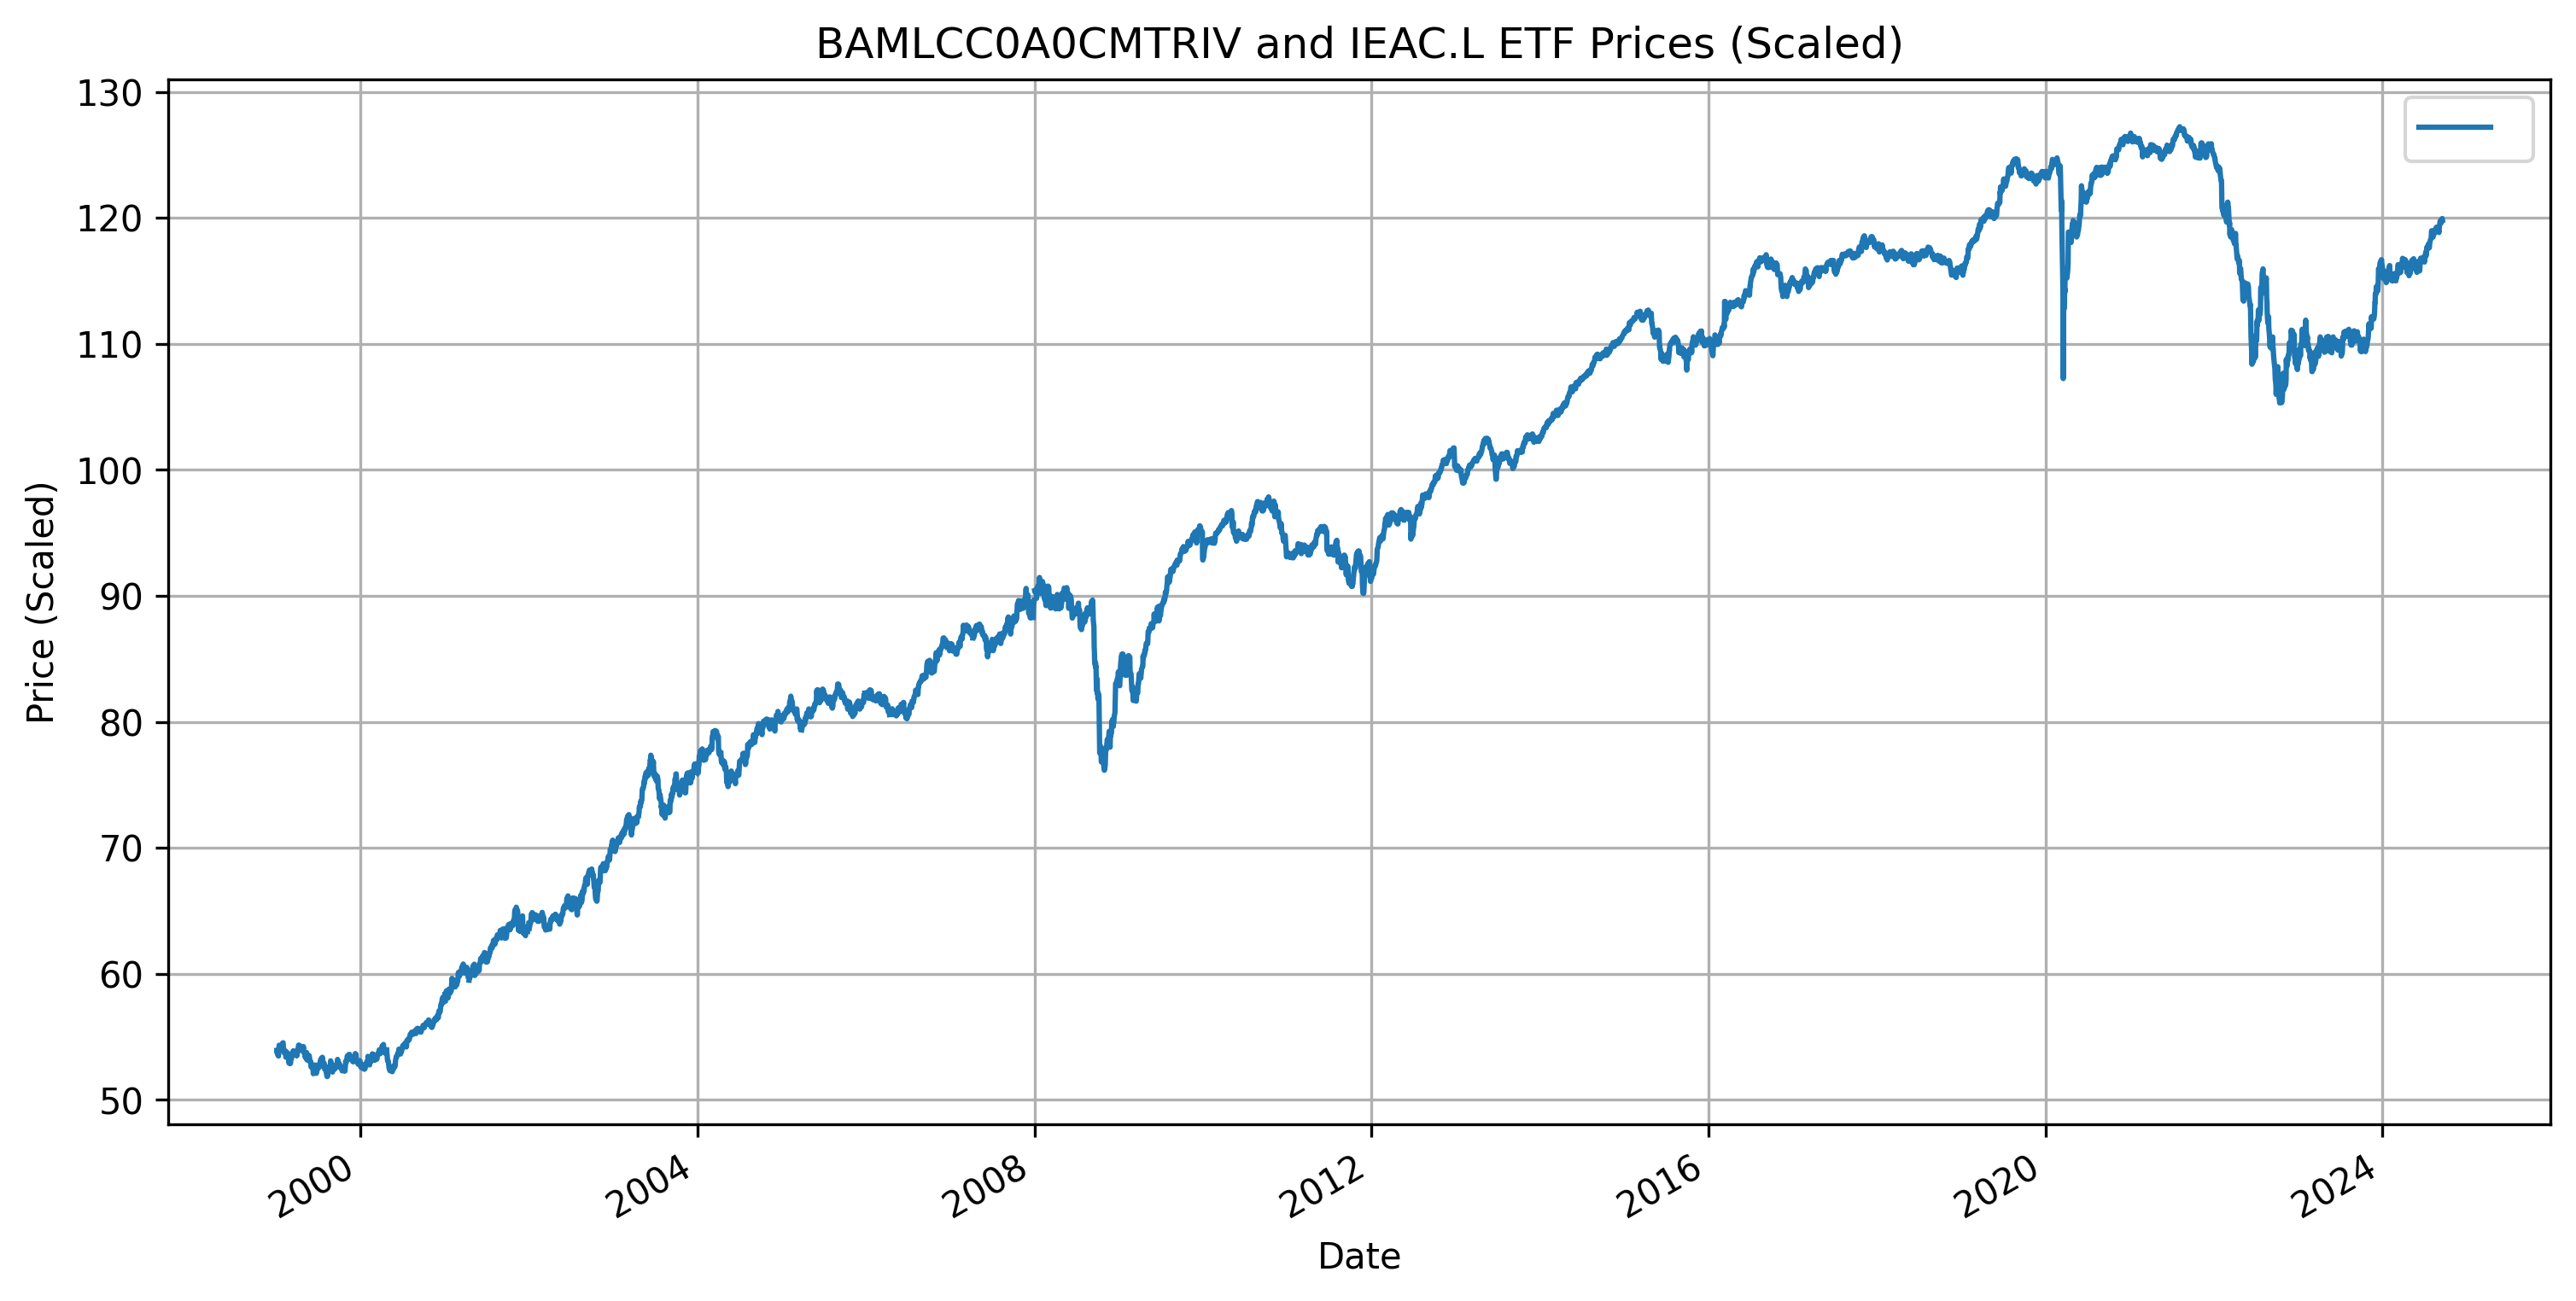

In [4]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

csv_data = pd.read_csv('data/BAMLCC0A0CMTRIV.csv', parse_dates=['DATE'], index_col='DATE')

# Replace missing values ('.') with NaN and convert the column to numeric
csv_data['BAMLCC0A0CMTRIV'] = pd.to_numeric(csv_data['BAMLCC0A0CMTRIV'], errors='coerce')

etf_data = yf.download('IEAC.L', start='1990-01-01', end='2024-09-18')

# Check if data was fetched successfully
if csv_data.empty or etf_data.empty:
    print("Failed to fetch data for one or both datasets.")
else:
    # Get the first date where IEAC.L data is available
    first_etf_date = etf_data.first_valid_index()
    print(f"First available date for IEAC.L: {first_etf_date.date()}")

    # Get the CSV data up to the day before IEAC.L data starts
    csv_data_trimmed = csv_data.loc[csv_data.index < first_etf_date].copy()

    # Ensure there is overlapping data
    if csv_data_trimmed.empty:
        print("No overlapping data found before IEAC.L starts.")
    else:
        last_csv_value = csv_data_trimmed['BAMLCC0A0CMTRIV'].iloc[-1]

        # Get the first 'Adj Close' value of IEAC.L
        first_etf_value = etf_data['Adj Close'].iloc[0]

        # Calculate scaling factor to align the two datasets
        scaling_factor = first_etf_value / last_csv_value

        # Scale the entire CSV 'BAMLC0A4CBBB' dataset to smoothly match the ETF values
        csv_data_trimmed['BAMLCC0A0CMTRIV'] = csv_data_trimmed['BAMLCC0A0CMTRIV'] * scaling_factor

        # Extract 'BAMLC0A4CBBB' column from CSV data and 'Adj Close' from ETF data
        csv_series = csv_data_trimmed['BAMLCC0A0CMTRIV']
        etf_adj_close = etf_data['Adj Close']

        # Concatenate the two series (CSV and ETF)
        euro_corp_bonds = pd.concat([csv_series, etf_adj_close])

        # Plot the combined data for smooth transition
        plt.figure(figsize=(12, 6), dpi=300)
        euro_corp_bonds.plot(title='BAMLCC0A0CMTRIV and IEAC.L ETF Prices (Scaled)', legend=True)
        plt.xlabel('Date')
        plt.ylabel('Price (Scaled)')
        plt.grid(True)
        plt.show()

        # Optional: Save the combined data to a CSV file
        euro_corp_bonds.to_csv('euro_corp_bonds.csv', header=['Price'])

Columns in returns_df: ['SP500', 'Gold', 'US_Treasury_Bills', 'Euro Corp bonds']


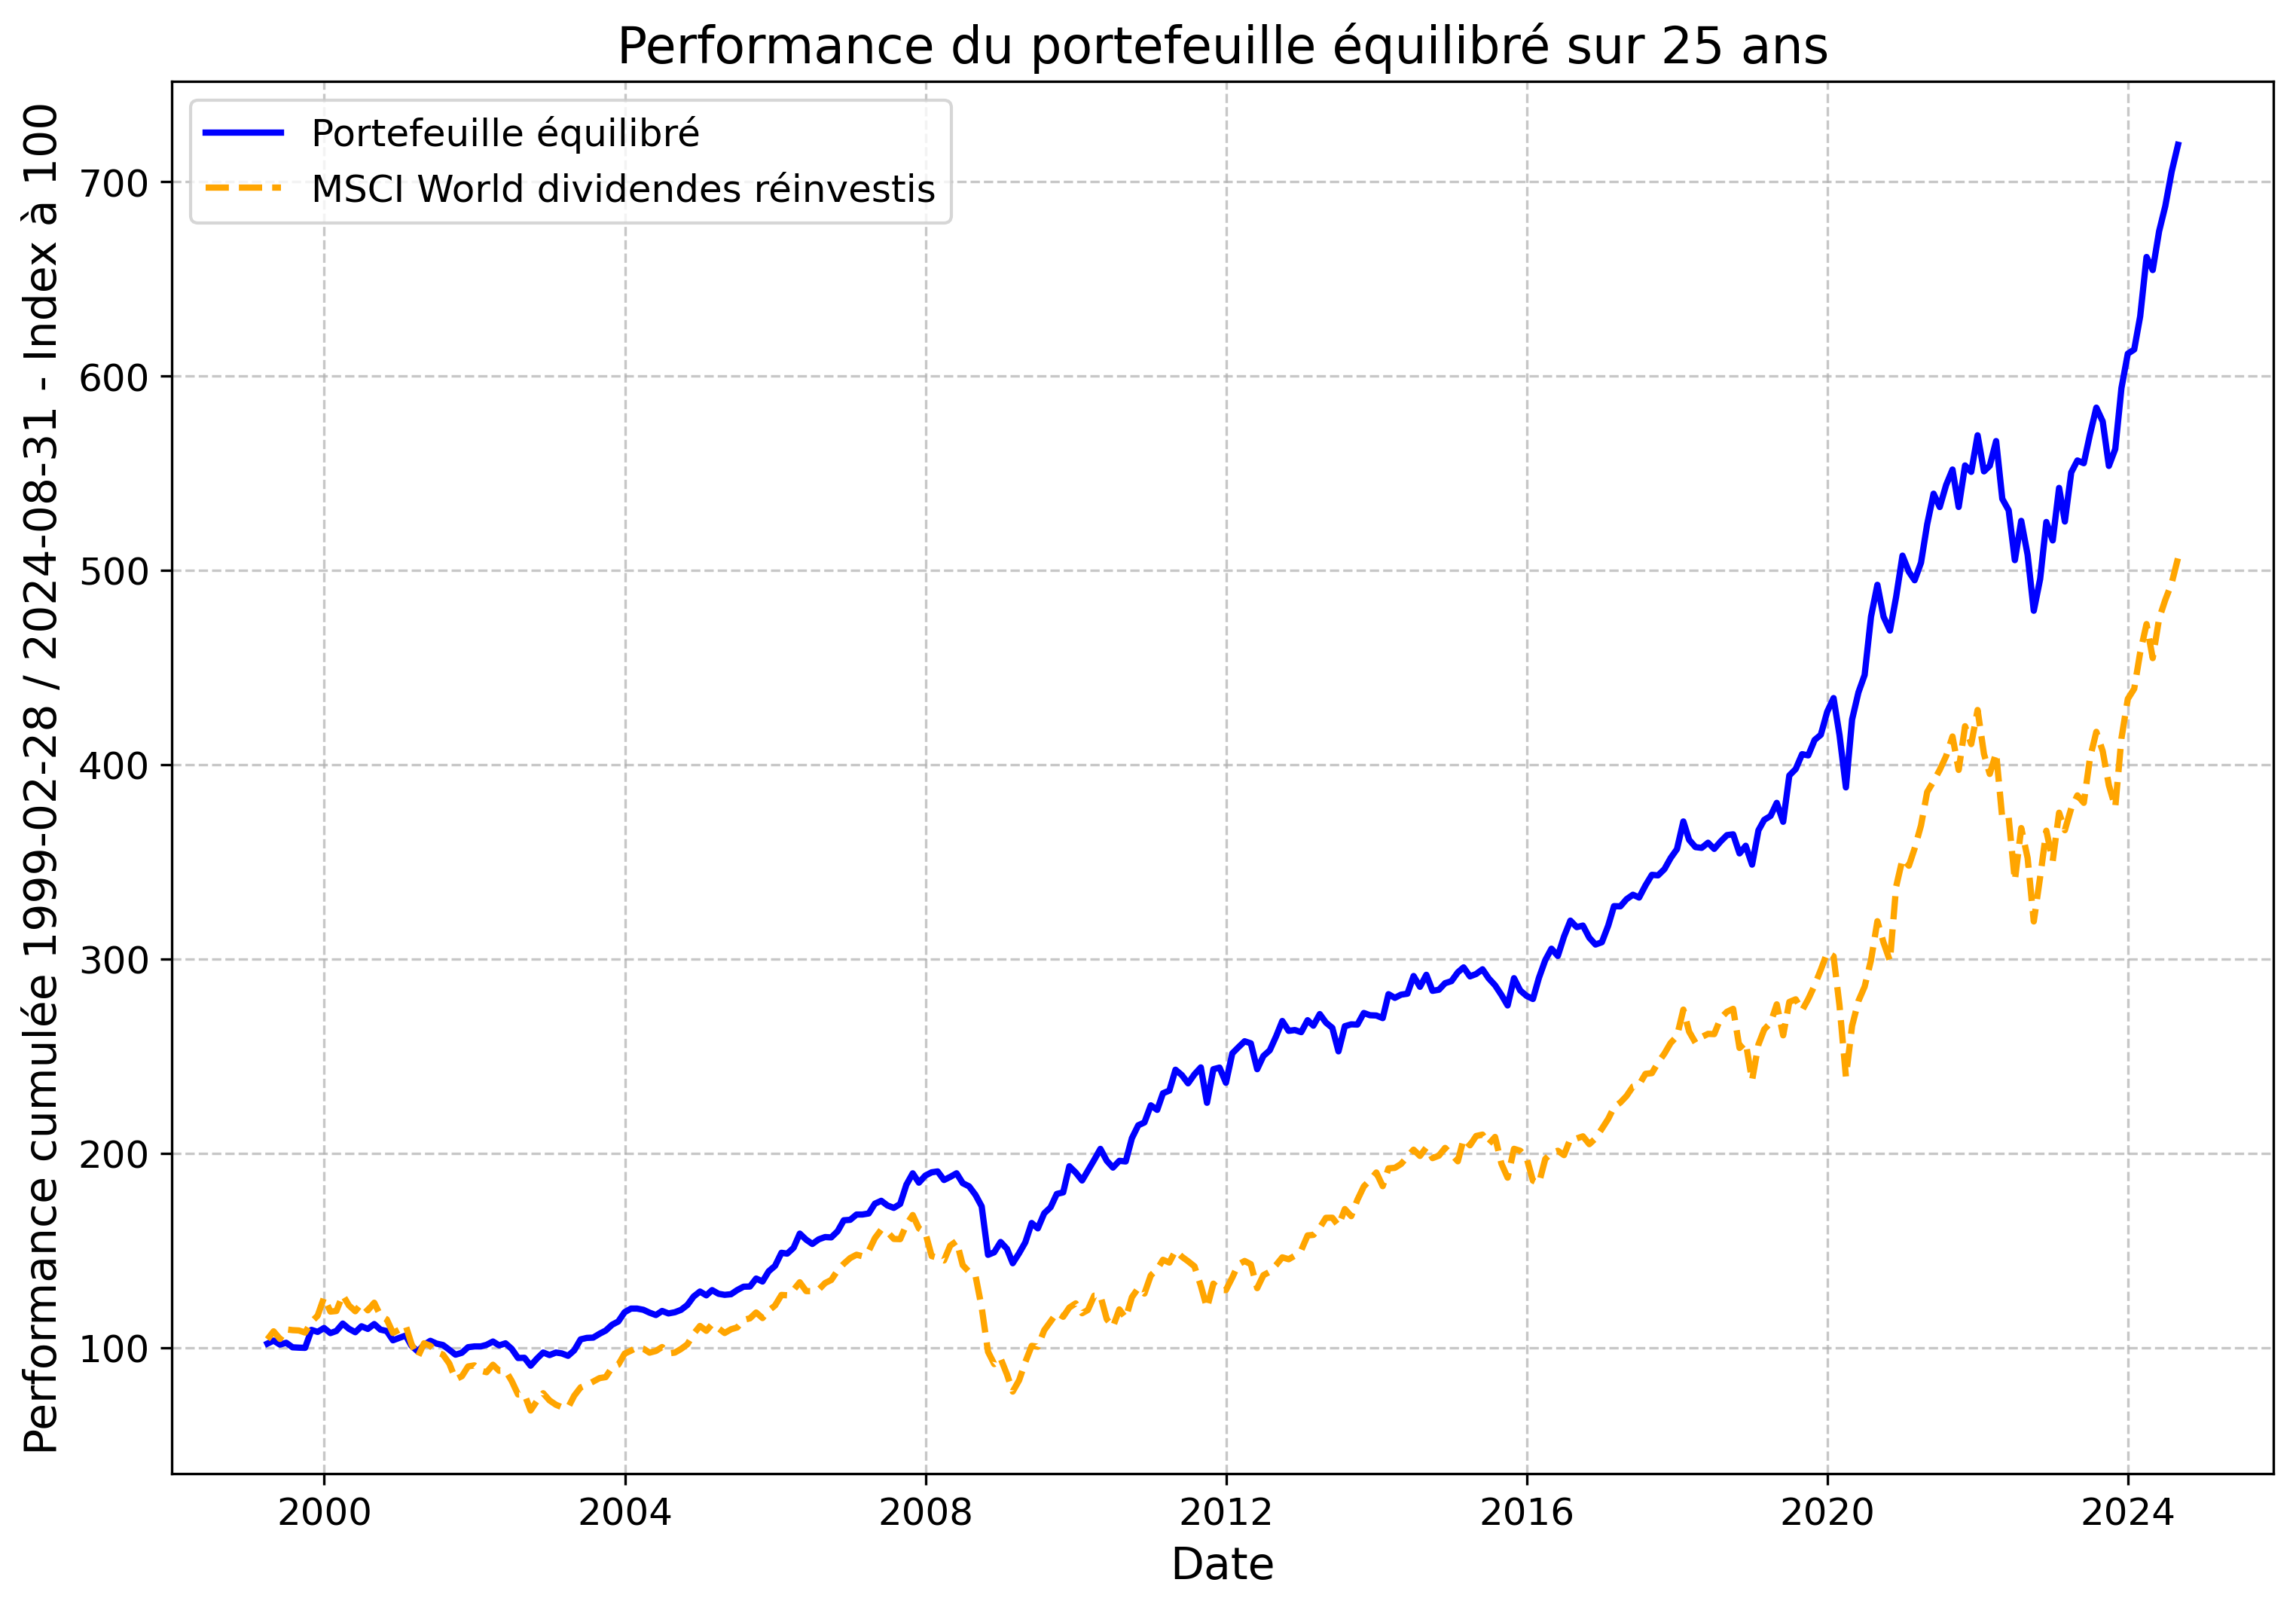

In [5]:
# Step 1: Extract the 'Adj Close' (or appropriate) column and resample to monthly data
sp_monthly = sp_data['Adj Close'].resample('M').last()
gold_monthly = gold_spot['Adjusted Close'].resample('M').last()
tbills_data_monthly = tbills_data['ETF Index'].resample('M').last()
euro_corp_bonds_monthly = euro_corp_bonds.resample('M').last()  # Adjust column name if different

# Step 2: Compute monthly percentage returns and assign a name to each Series
sp_returns = sp_monthly.pct_change().dropna()
sp_returns.name = 'SP500'

gold_returns = gold_monthly.pct_change().dropna()
gold_returns.name = 'Gold'

tbills_data_returns = tbills_data_monthly.pct_change().dropna()
tbills_data_returns.name = 'US_Treasury_Bills'

eurobonds_returns = euro_corp_bonds_monthly.pct_change().dropna()
eurobonds_returns.name = 'Euro Corp bonds'

# Step 3: Combine the returns into a DataFrame
returns_df = pd.concat(
    [
        sp_returns,
        gold_returns,
        tbills_data_returns,
        eurobonds_returns,
    ],
    axis=1
)

# Step 4: Drop rows with NaN values to align the dates
returns_df.dropna(inplace=True)

# Optional: Verify that the DataFrame now has 6 columns
print(f"Columns in returns_df: {returns_df.columns.tolist()}")  # Should list all 6 asset names

# Step 5: Define your portfolio weights
weights = [0.5, 0.35, 0.1, 0.05]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights) for w in weights]

# Step 6: Compute the portfolio returns
portfolio_returns = returns_df.dot(weights)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed = 100 * (1 + portfolio_returns).cumprod()

# For the benchmark, assuming you have MSCI World data:
# Resample to monthly data
msci_world_monthly = msci_world_data['MSCI World Net Return'].resample('M').last()

# Compute monthly returns
msci_world_returns = msci_world_monthly.pct_change().dropna()
msci_world_returns.name = 'MSCI_World'

# Align dates with portfolio returns
benchmark_returns = msci_world_returns.reindex(portfolio_returns.index).dropna()

# Compute cumulative returns for the benchmark
msci_world_cumulative_returns_indexed = 100 * (1 + benchmark_returns).cumprod()

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed.index = pd.to_datetime(cumulative_returns_indexed.index)

aggressive_portfolio = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed, label='Portefeuille équilibré', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World dividendes réinvestis', color='orange', linestyle='--', linewidth=2)
plt.title('Performance du portefeuille équilibré sur 25 ans', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Performance cumulée 1999-02-28 / 2024-08-31 - Index à 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [6]:
global_stats1 = ffn.calc_stats(cumulative_returns_indexed)
global_stats1.set_riskfree_rate(0.0164)
global_stats1.display()

Stats for None from 1999-03-31 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 1.64%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
604.97%         -         7.99%   -24.79%

Annualized Returns:
mtd    3m     6m      ytd     1y      3y     5y      10y    incep.
-----  -----  ------  ------  ------  -----  ------  -----  --------
1.97%  6.60%  14.01%  17.58%  24.70%  9.22%  12.14%  9.44%  7.99%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.67       0.60
mean    -        8.19%      8.38%
vol     -        9.81%      11.17%
skew    -        -0.40      -0.62
kurt    -        2.46       -0.36
best    -        9.26%      23.16%
worst   -        -14.45%    -18.12%

Drawdowns:
max      avg       # days
-------  ------  --------
-24.79%  -3.98%     139.8

Misc:
---------------  ------
avg. up month    2.39%
avg. down month  -2.03%
up year %        72.00%
12m up %    

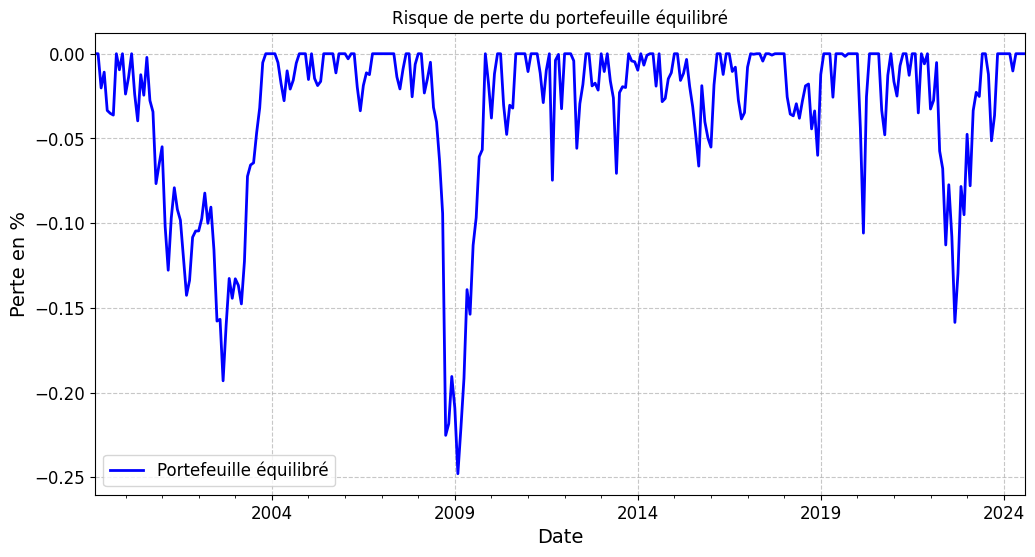

In [7]:
# Plot the drawdown series for the aggressive portfolio
drawdown1 = global_stats1.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Risque de perte du portefeuille équilibré', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Perte en %', fontsize=14)
plt.legend(['Portefeuille équilibré'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

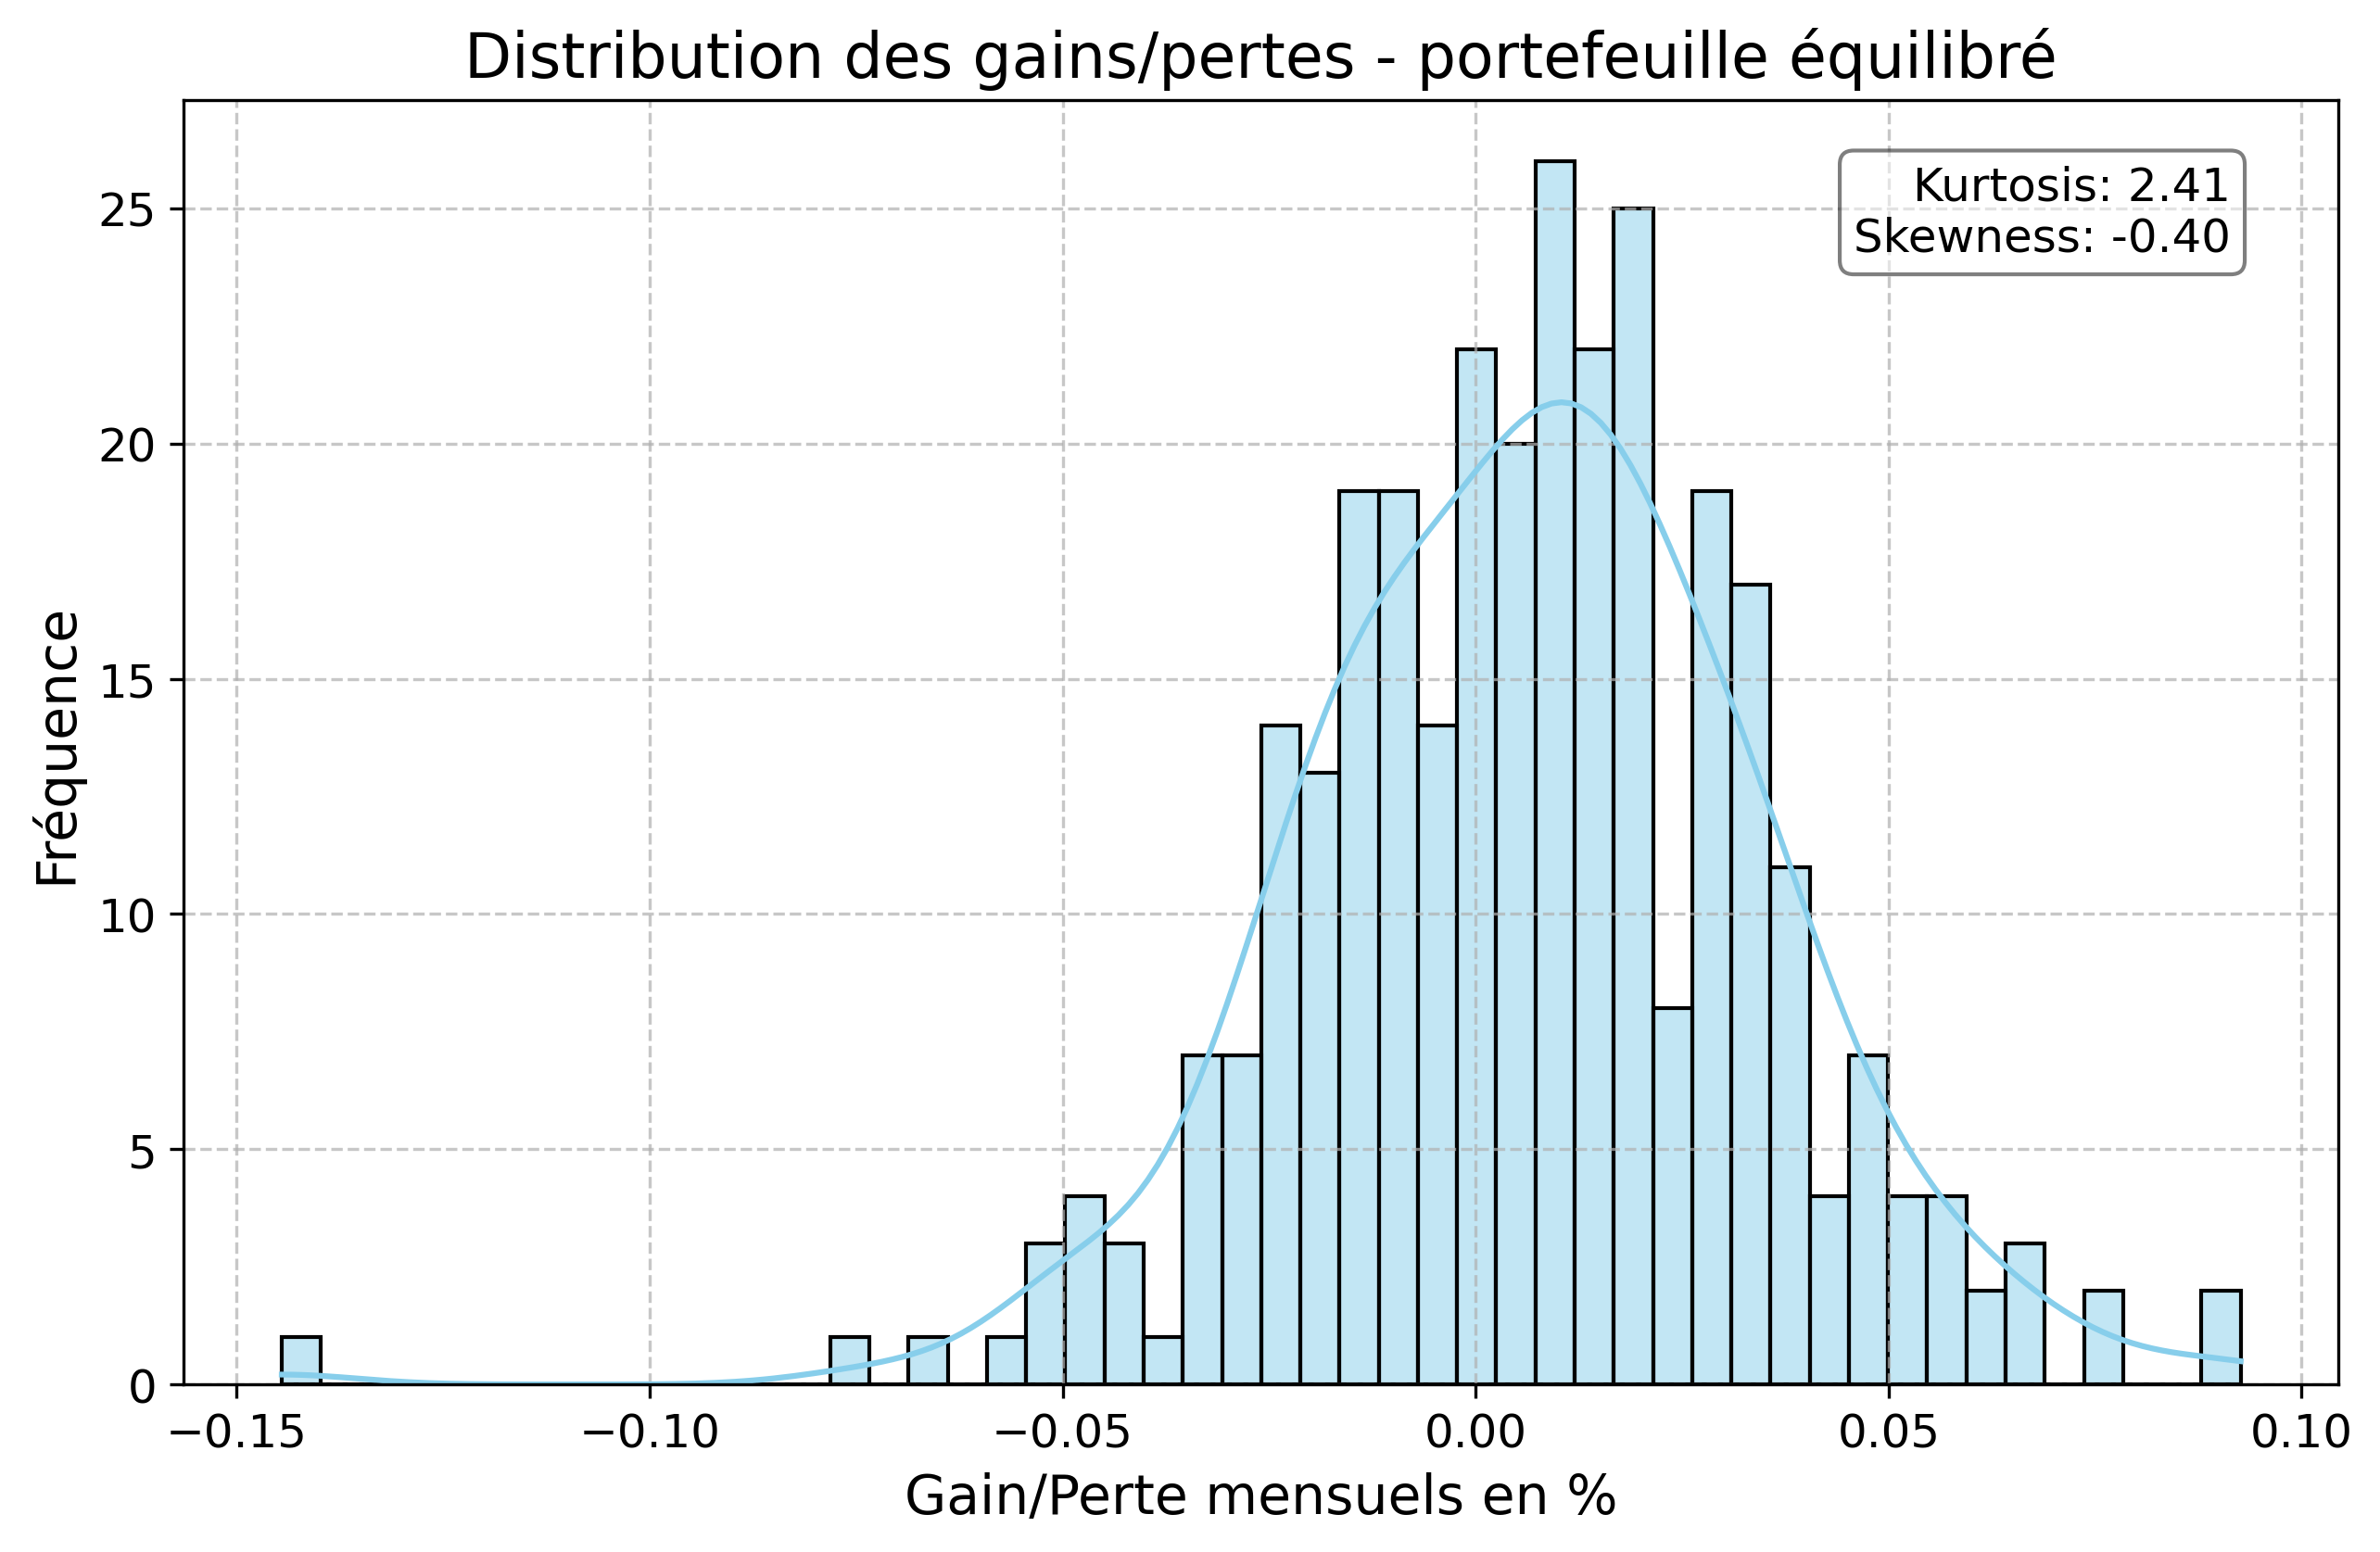

In [8]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns)
skewness = skew(portfolio_returns)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Distribution des gains/pertes - portefeuille équilibré', fontsize=16)
plt.xlabel('Gain/Perte mensuels en %', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

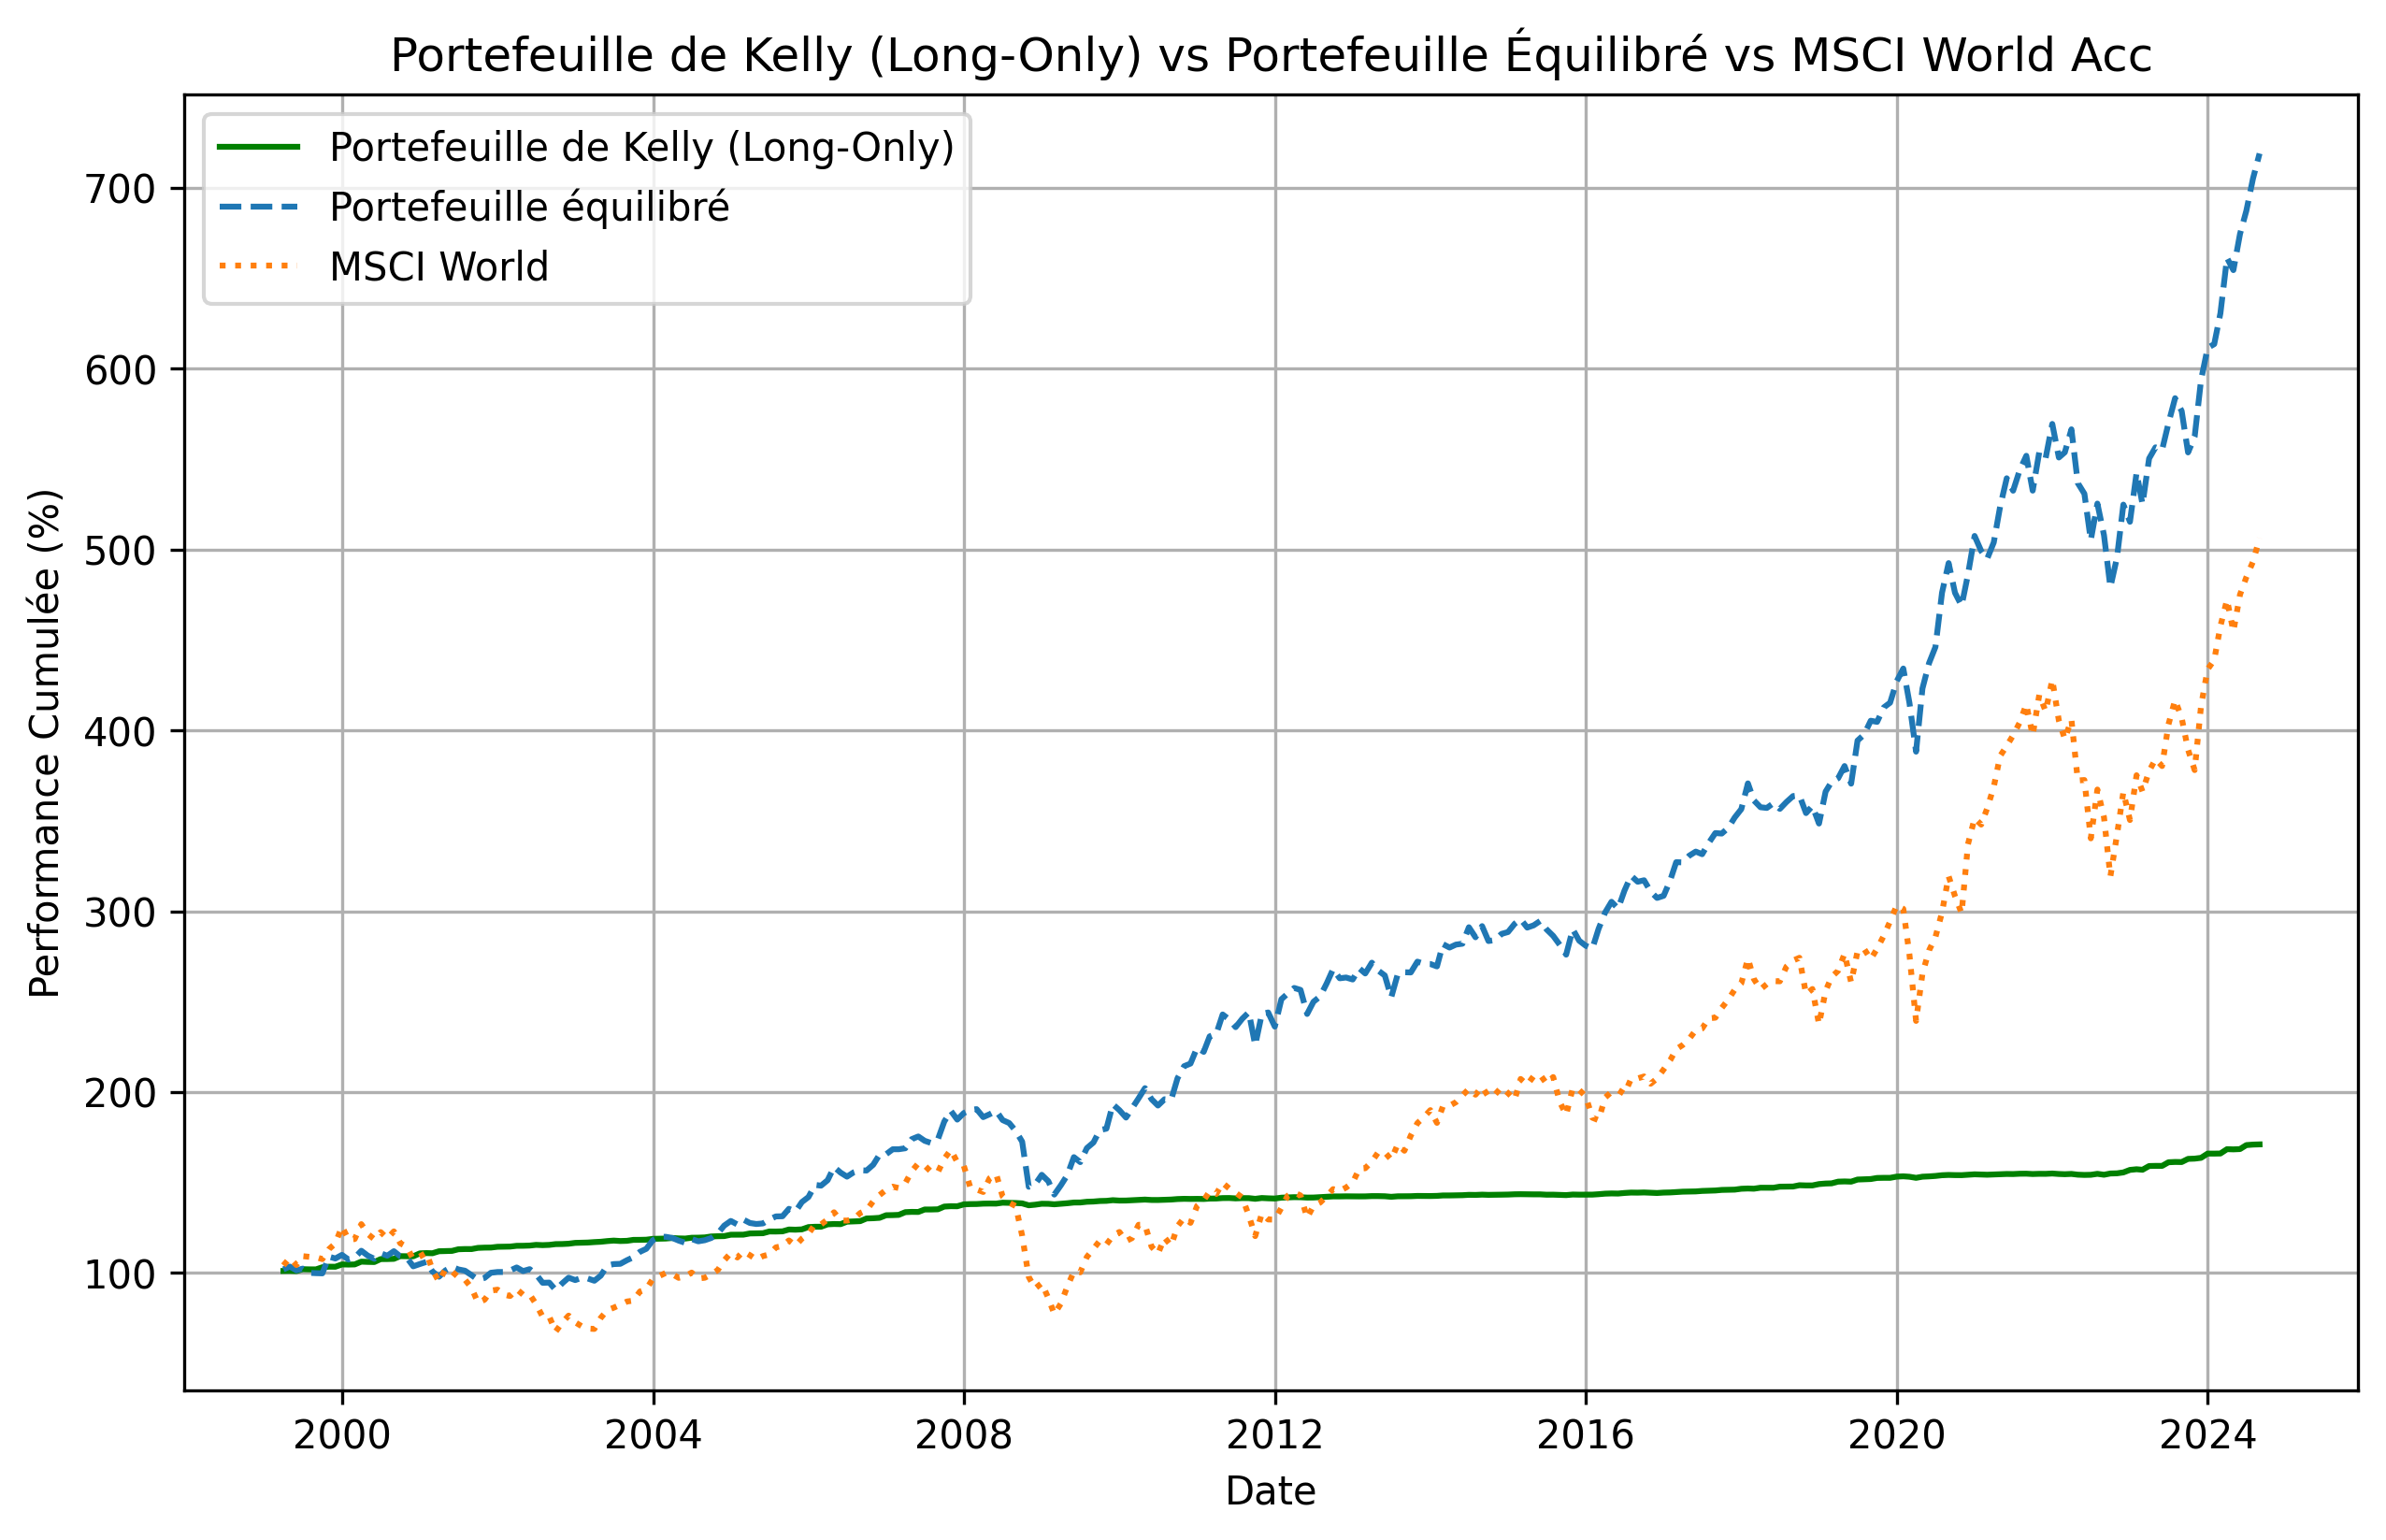

,Asset,Kelly Weights (Long-Only)
0,SP500,0.012830
1,Gold,0.011974
2,US_Treasury_Bills,0.927257
3,Euro Corp bonds,0.047939


In [9]:
from scipy.optimize import minimize

expected_returns = returns_df.mean()  # Use the mean returns of individual assets
cov_matrix = returns_df.cov()  # Covariance matrix of the asset returns

# Step 1: Define the objective function (negative Kelly's criterion to minimize)
def kelly_criterion(weights, expected_returns, cov_matrix):
    # Negative of Kelly formula (since we are minimizing)
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return -portfolio_return / portfolio_variance

# Step 2: Define constraints and bounds (no shorting or leverage)
num_assets = len(expected_returns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No shorting, weights between 0 and 1

# Step 3: Initial guess for weights (equal weight allocation)
initial_weights = num_assets * [1. / num_assets]

# Step 4: Optimize using scipy's minimize function
result = minimize(kelly_criterion, initial_weights, args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Step 5: Get the optimized Kelly weights
kelly_weights_long_only = result.x

# Step 6: Compute the Kelly portfolio returns using the optimized weights
kelly_portfolio_returns_long_only = returns_df.dot(kelly_weights_long_only)

# Step 7: Compute cumulative returns for the long-only Kelly portfolio
kelly_cumulative_returns_long_only = (1 + kelly_portfolio_returns_long_only).cumprod() * 100

# Step 8: Plot the performance of the long-only Kelly portfolio and compare it with the aggressive portfolio and MSCI World
plt.figure(figsize=(10, 6), dpi=300)

# Plot long-only Kelly portfolio cumulative returns
plt.plot(kelly_cumulative_returns_long_only, label='Portefeuille de Kelly (Long-Only)', color='green')

# Plot aggressive portfolio cumulative returns
plt.plot(cumulative_returns_indexed, label='Portefeuille équilibré', linestyle='--')

# Plot MSCI World cumulative returns
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World', linestyle=':')

plt.title('Portefeuille de Kelly (Long-Only) vs Portefeuille Équilibré vs MSCI World Acc')
plt.xlabel('Date')
plt.ylabel('Performance Cumulée (%)')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized Kelly weights for each asset
kelly_weights_long_only_df = pd.DataFrame({
    'Asset': returns_df.columns,
    'Kelly Weights (Long-Only)': kelly_weights_long_only
})
kelly_weights_long_only_df

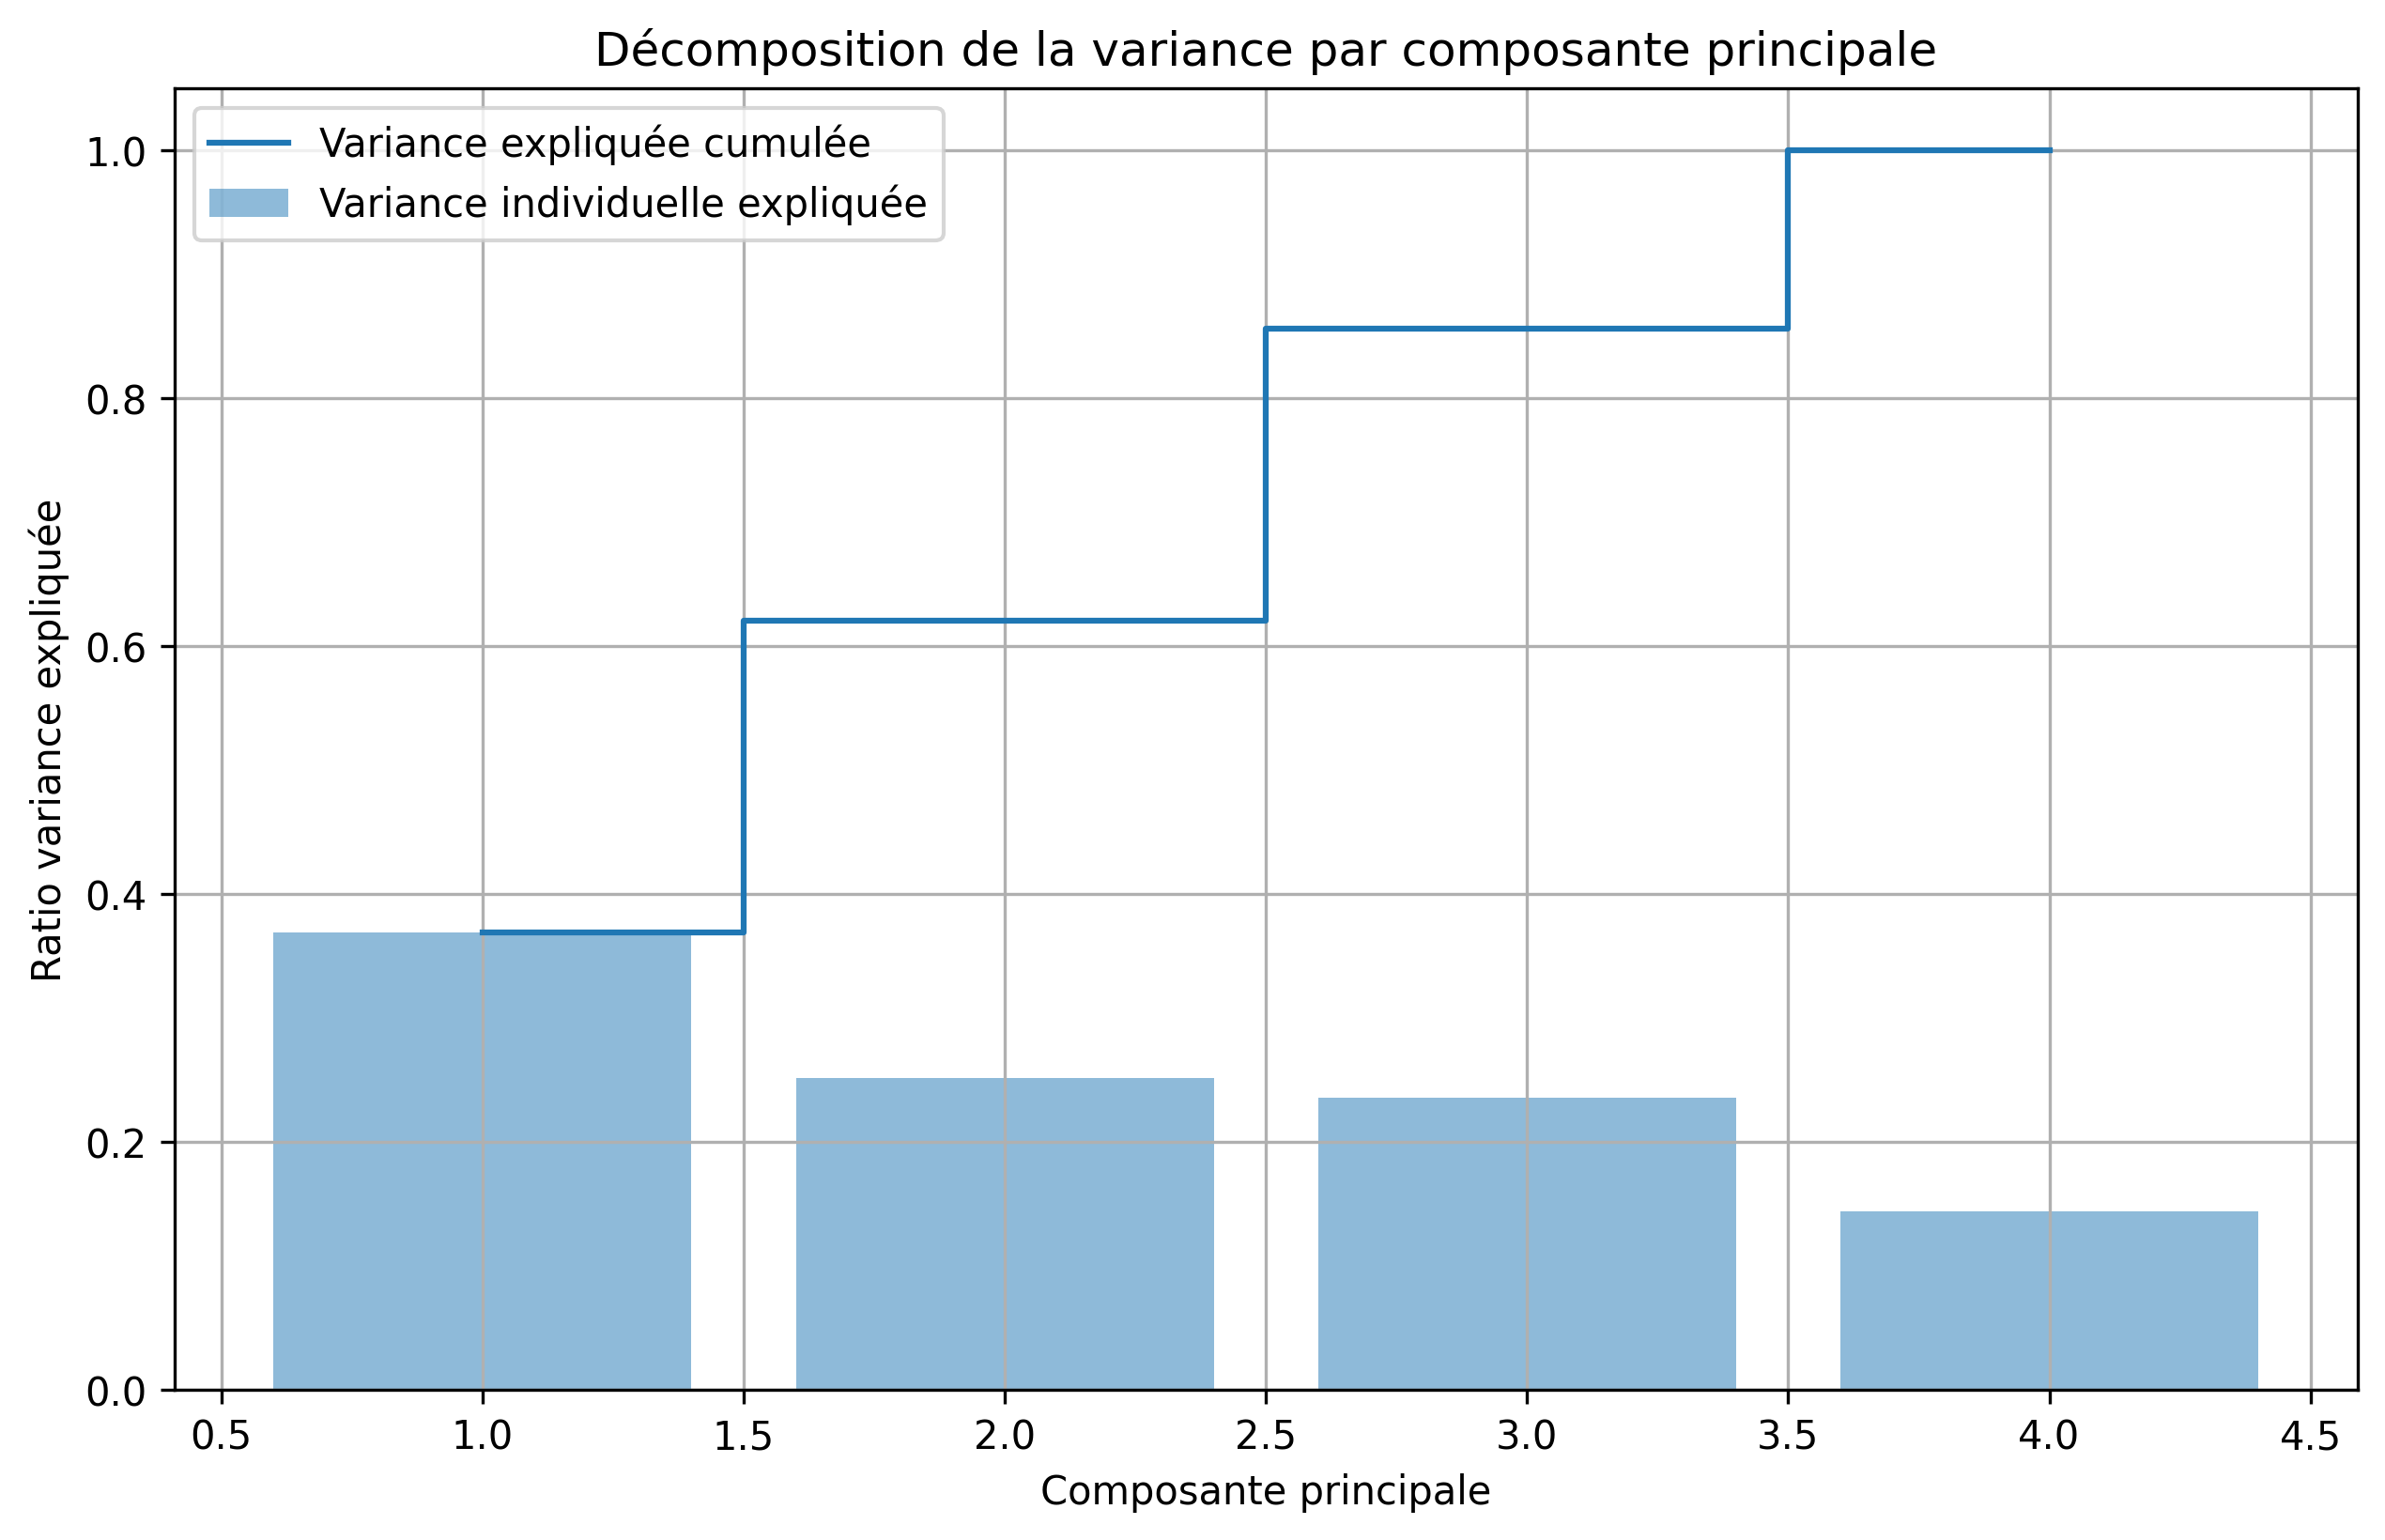

,SP500,Gold,US_Treasury_Bills,Euro Corp bonds
PC1,0.577287,0.441786,-0.046661,0.685119
PC2,-0.179762,0.263603,0.946619,0.045960
PC3,-0.548723,0.771748,-0.316350,-0.056834
PC4,-0.577346,-0.373822,-0.040728,0.724755


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_df)

# Step 2: Perform PCA
pca = PCA()
pca.fit(returns_scaled)

# Step 3: Get the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Variance expliquée cumulée')
plt.title('Décomposition de la variance par composante principale')
plt.xlabel('Composante principale')
plt.ylabel('Ratio variance expliquée')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Display the PCA components (principal axes in feature space)
pca_components = pd.DataFrame(pca.components_, columns=returns_df.columns, index=[f'PC{i+1}' for i in range(len(returns_df.columns))])
pca_components

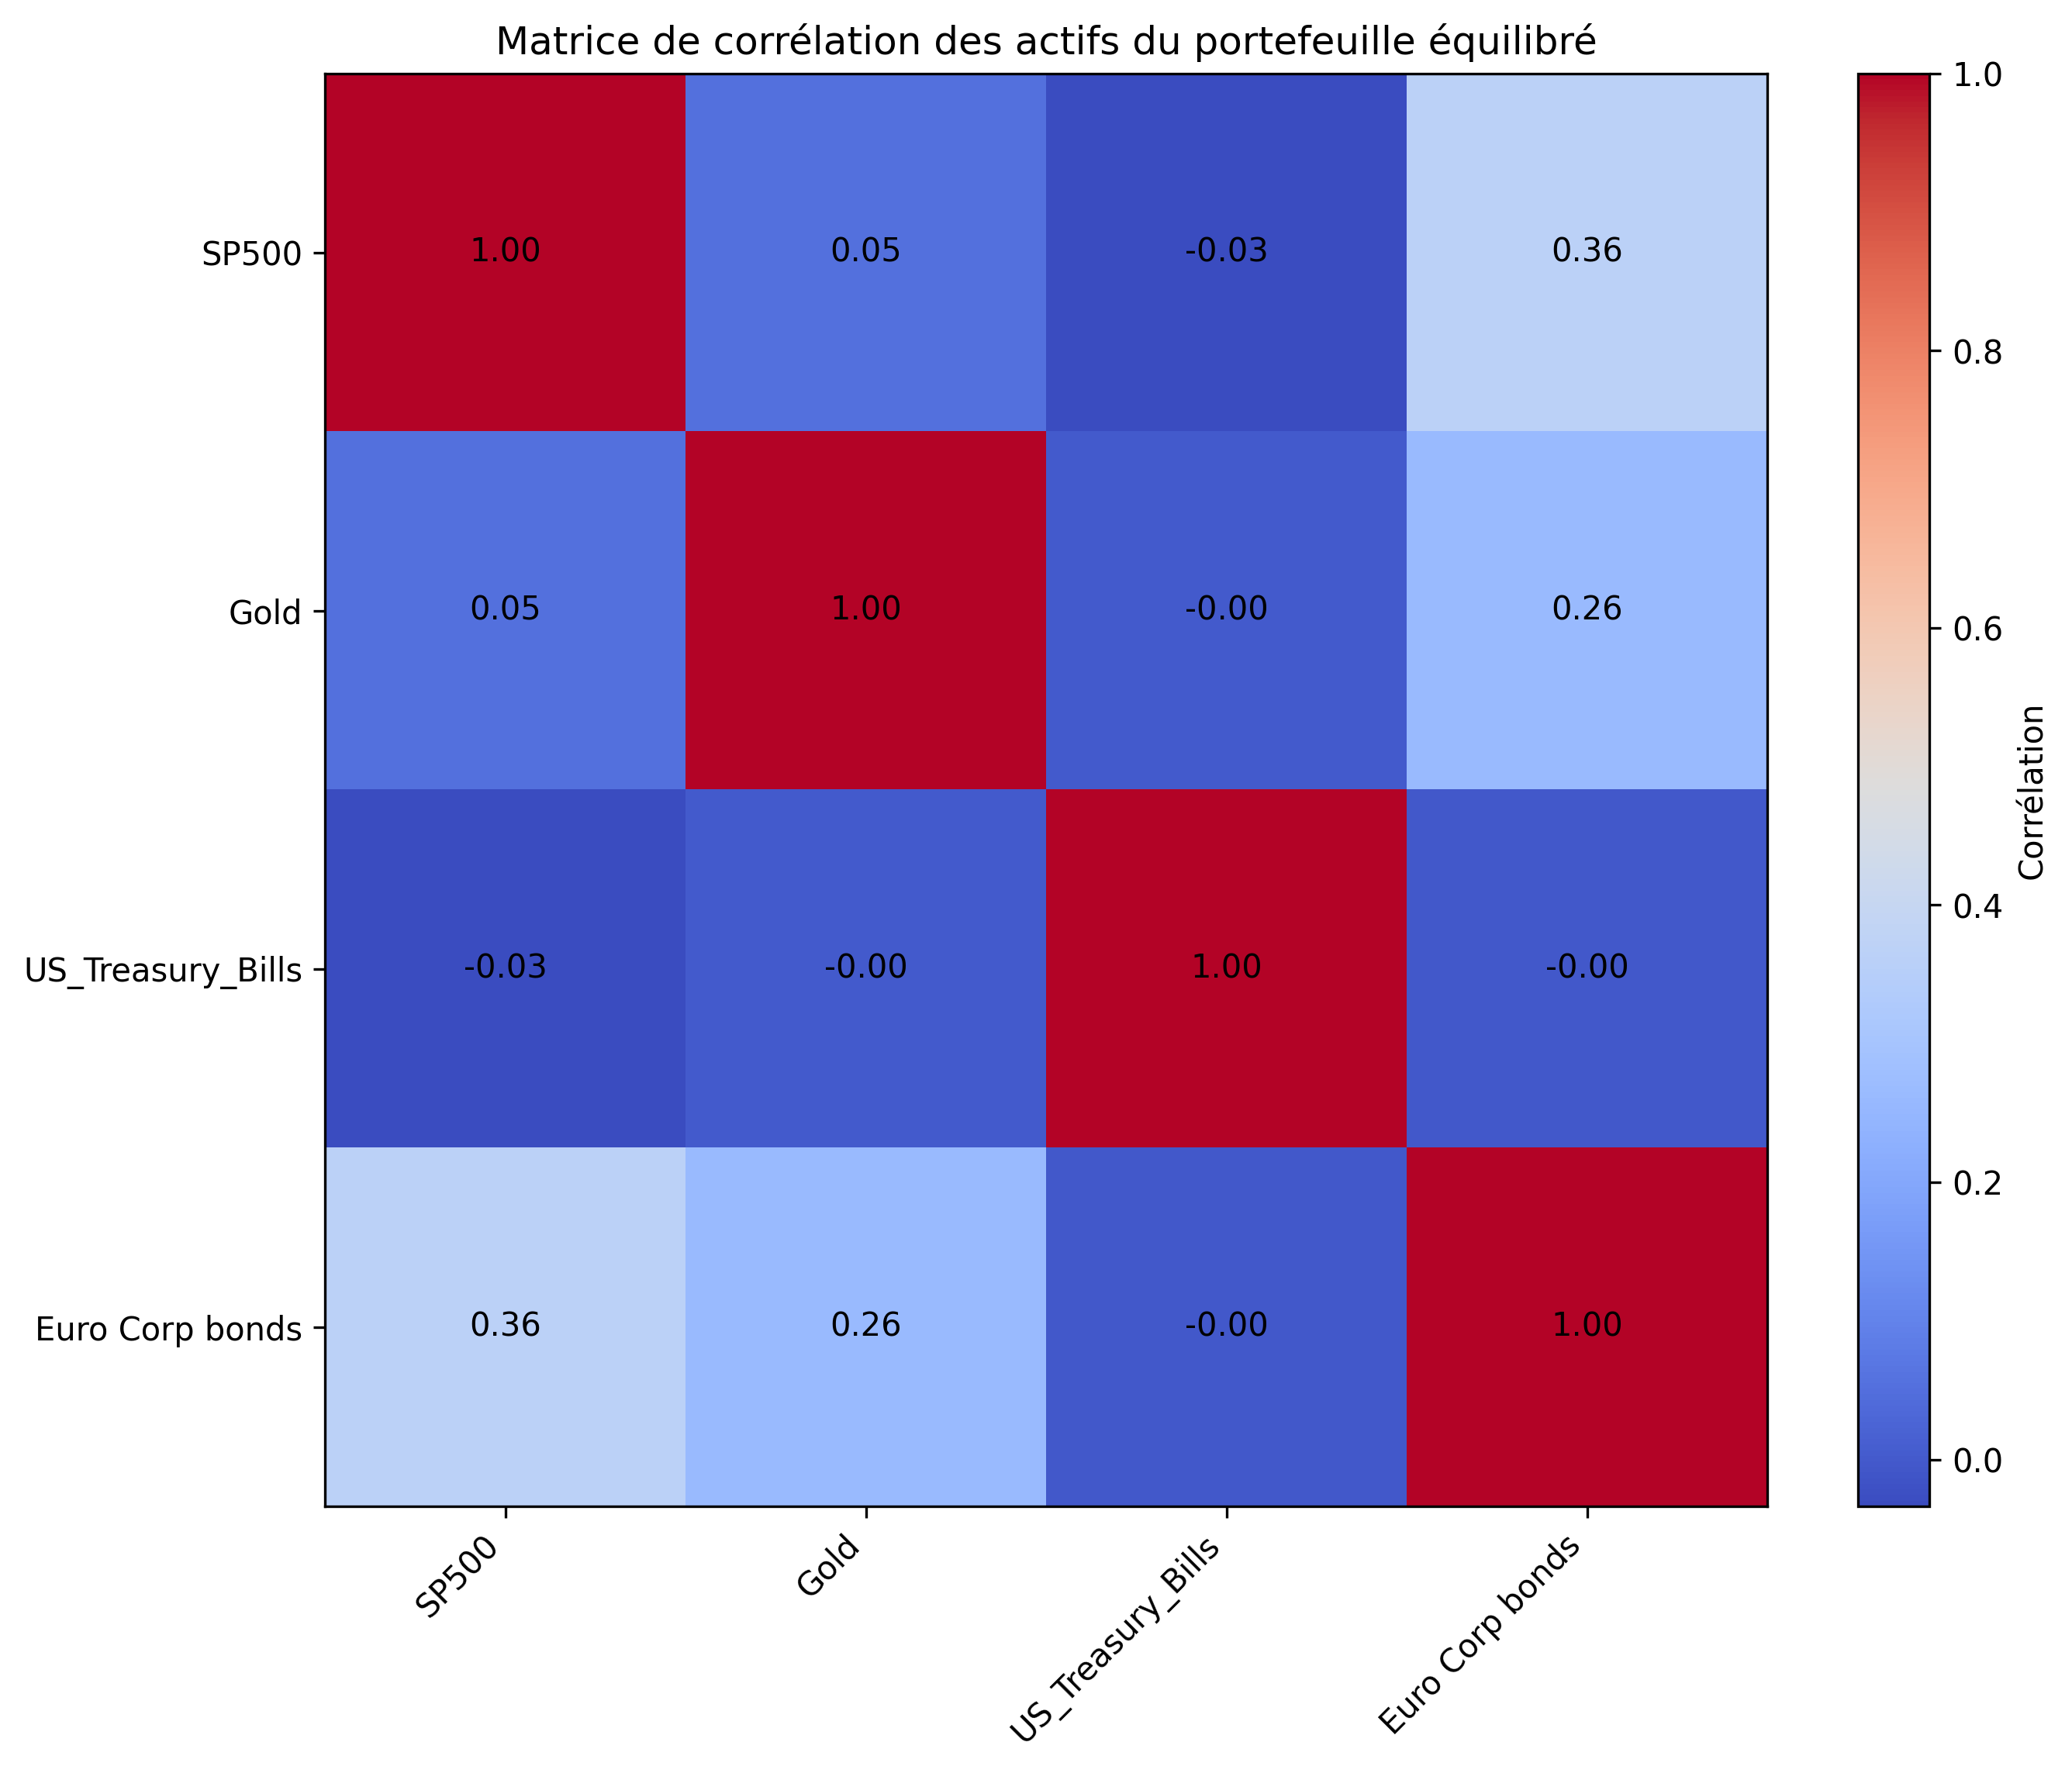

,SP500,Gold,US_Treasury_Bills,Euro Corp bonds
SP500,1.000000,0.053372,-0.033641,0.363402
Gold,0.053372,1.000000,-0.000880,0.261164
US_Treasury_Bills,-0.033641,-0.000880,1.000000,-0.003426
Euro Corp bonds,0.363402,0.261164,-0.003426,1.000000


In [11]:
# Step 1: Compute the correlation matrix of the portfolio assets
correlation_matrix = returns_df.corr()

# Step 2: Plot the correlation matrix as a heatmap with numbers
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Corrélation')

# Add the correlation numbers on the heatmap
for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set x and y axis labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matrice de corrélation des actifs du portefeuille équilibré')
plt.grid(False)
plt.show()

# Step 3: Optionally, display the correlation matrix as a DataFrame
correlation_matrix

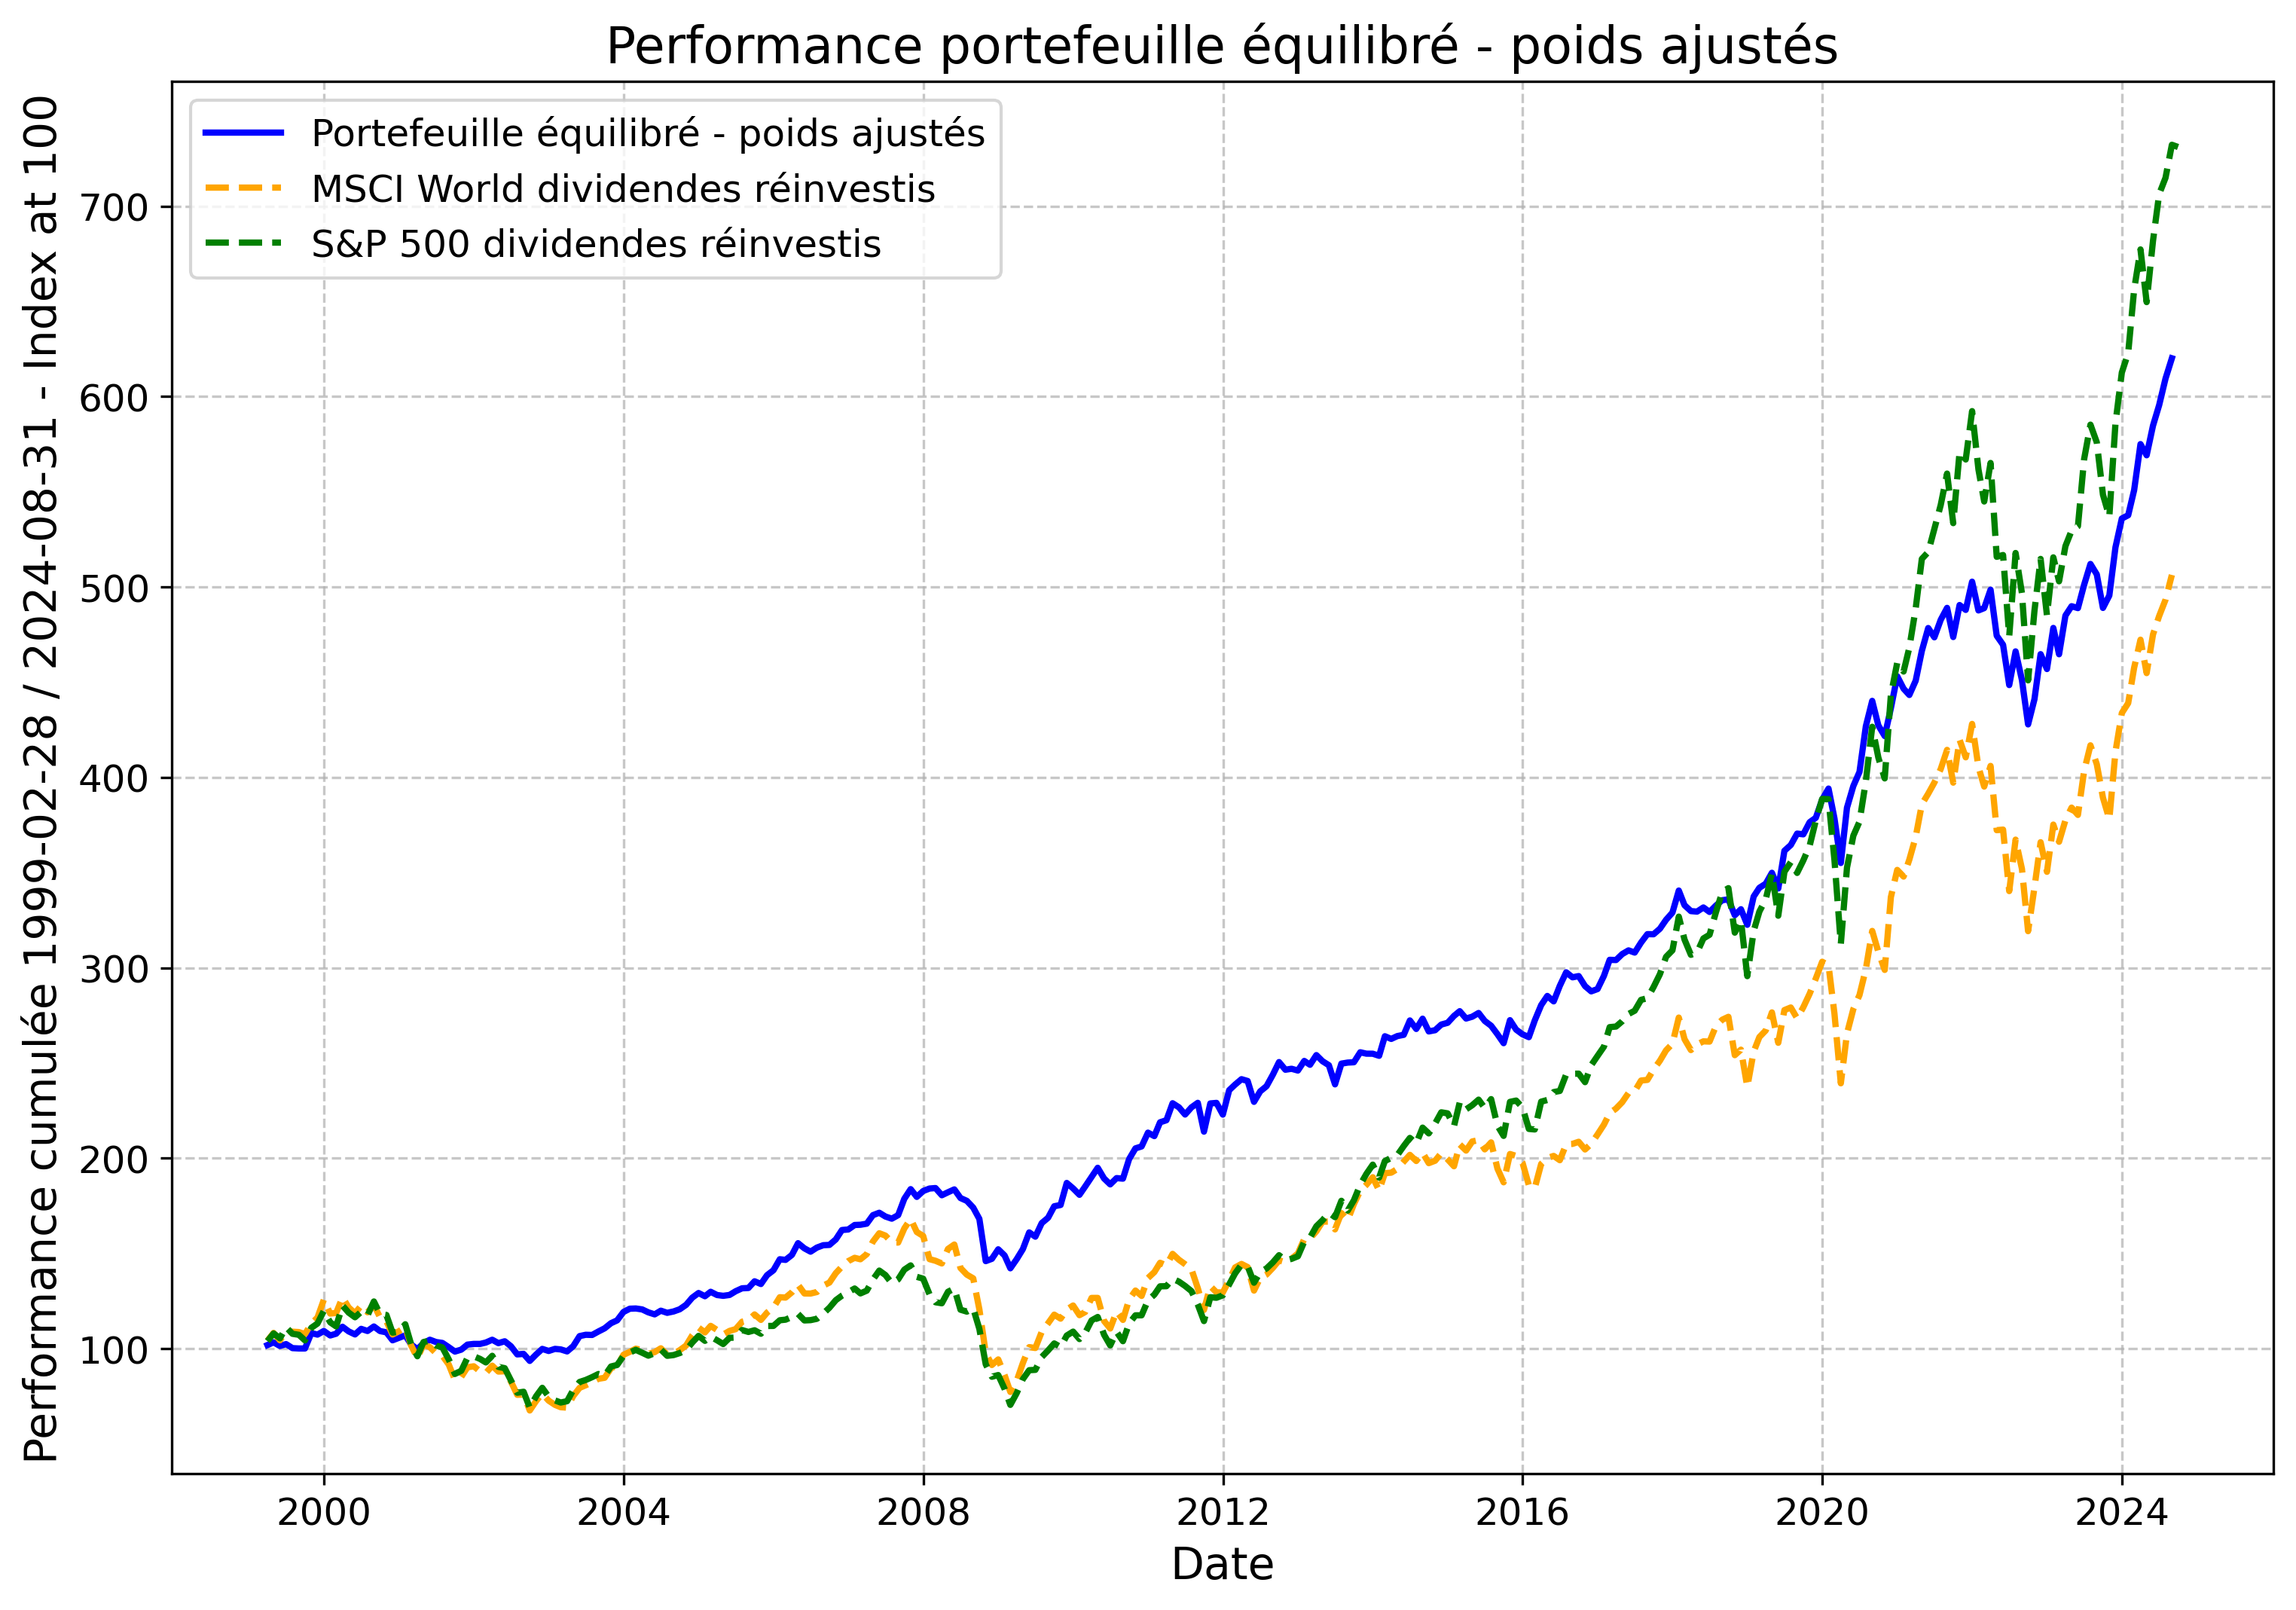

In [12]:
# Step 5: Define your portfolio weights
weights2 = [0.45, 0.3, 0.15, 0.1]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights2) for w in weights2]

# Step 6: Compute the portfolio returns
portfolio_returns2 = returns_df.dot(weights2)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed2 = 100 * (1 + portfolio_returns2).cumprod()

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed2.index = pd.to_datetime(cumulative_returns_indexed2.index)

# Add a 'Date' column to the DataFrame
cumulative_returns_indexed2_df = cumulative_returns_indexed2.reset_index()
cumulative_returns_indexed2_df.columns = ['Date', 'Cumulative_Returns']

# Save the DataFrame to an Excel file with a header
with pd.ExcelWriter('excel_équilibré.xlsx') as writer:
    cumulative_returns_indexed2_df.to_excel(writer, index=False, sheet_name='Portefeuille équilibré')

aggressive_portfolio2 = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed2
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed2, label='Portefeuille équilibré - poids ajustés', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World dividendes réinvestis', color='orange', linestyle='--', linewidth=2)
plt.plot(sp500_cumulative_returns_indexed, label='S&P 500 dividendes réinvestis', color='green', linestyle='--', linewidth=2)
plt.title('Performance portefeuille équilibré - poids ajustés', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Performance cumulée 1999-02-28 / 2024-08-31 - Index at 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('graph_équilibré', format='svg')
plt.show()

In [13]:
global_stats2 = ffn.calc_stats(cumulative_returns_indexed2)
global_stats2.set_riskfree_rate(0.0164)
global_stats2.display()

Stats for None from 1999-03-31 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 1.64%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
508.45%         -         7.36%   -22.86%

Annualized Returns:
mtd    3m     6m      ytd     1y      3y     5y      10y    incep.
-----  -----  ------  ------  ------  -----  ------  -----  --------
1.75%  6.05%  12.57%  15.70%  22.41%  8.24%  10.84%  8.54%  7.36%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.67       0.60
mean    -        7.51%      7.66%
vol     -        8.82%      10.03%
skew    -        -0.44      -0.67
kurt    -        2.61       -0.18
best    -        8.18%      21.01%
worst   -        -13.17%    -16.74%

Drawdowns:
max      avg       # days
-------  ------  --------
-22.86%  -3.54%    135.36

Misc:
---------------  ------
avg. up month    2.15%
avg. down month  -1.82%
up year %        72.00%
12m up %    

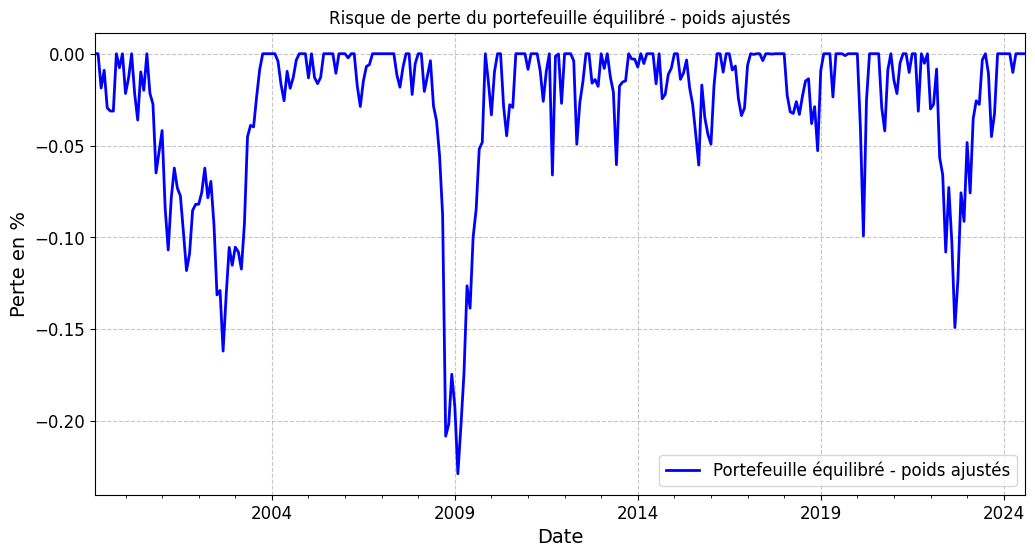

In [14]:
# Plot the drawdown series for the aggressive portfolio
drawdown2 = global_stats2.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Risque de perte du portefeuille équilibré - poids ajustés', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Perte en %', fontsize=14)
plt.legend(['Portefeuille équilibré - poids ajustés'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

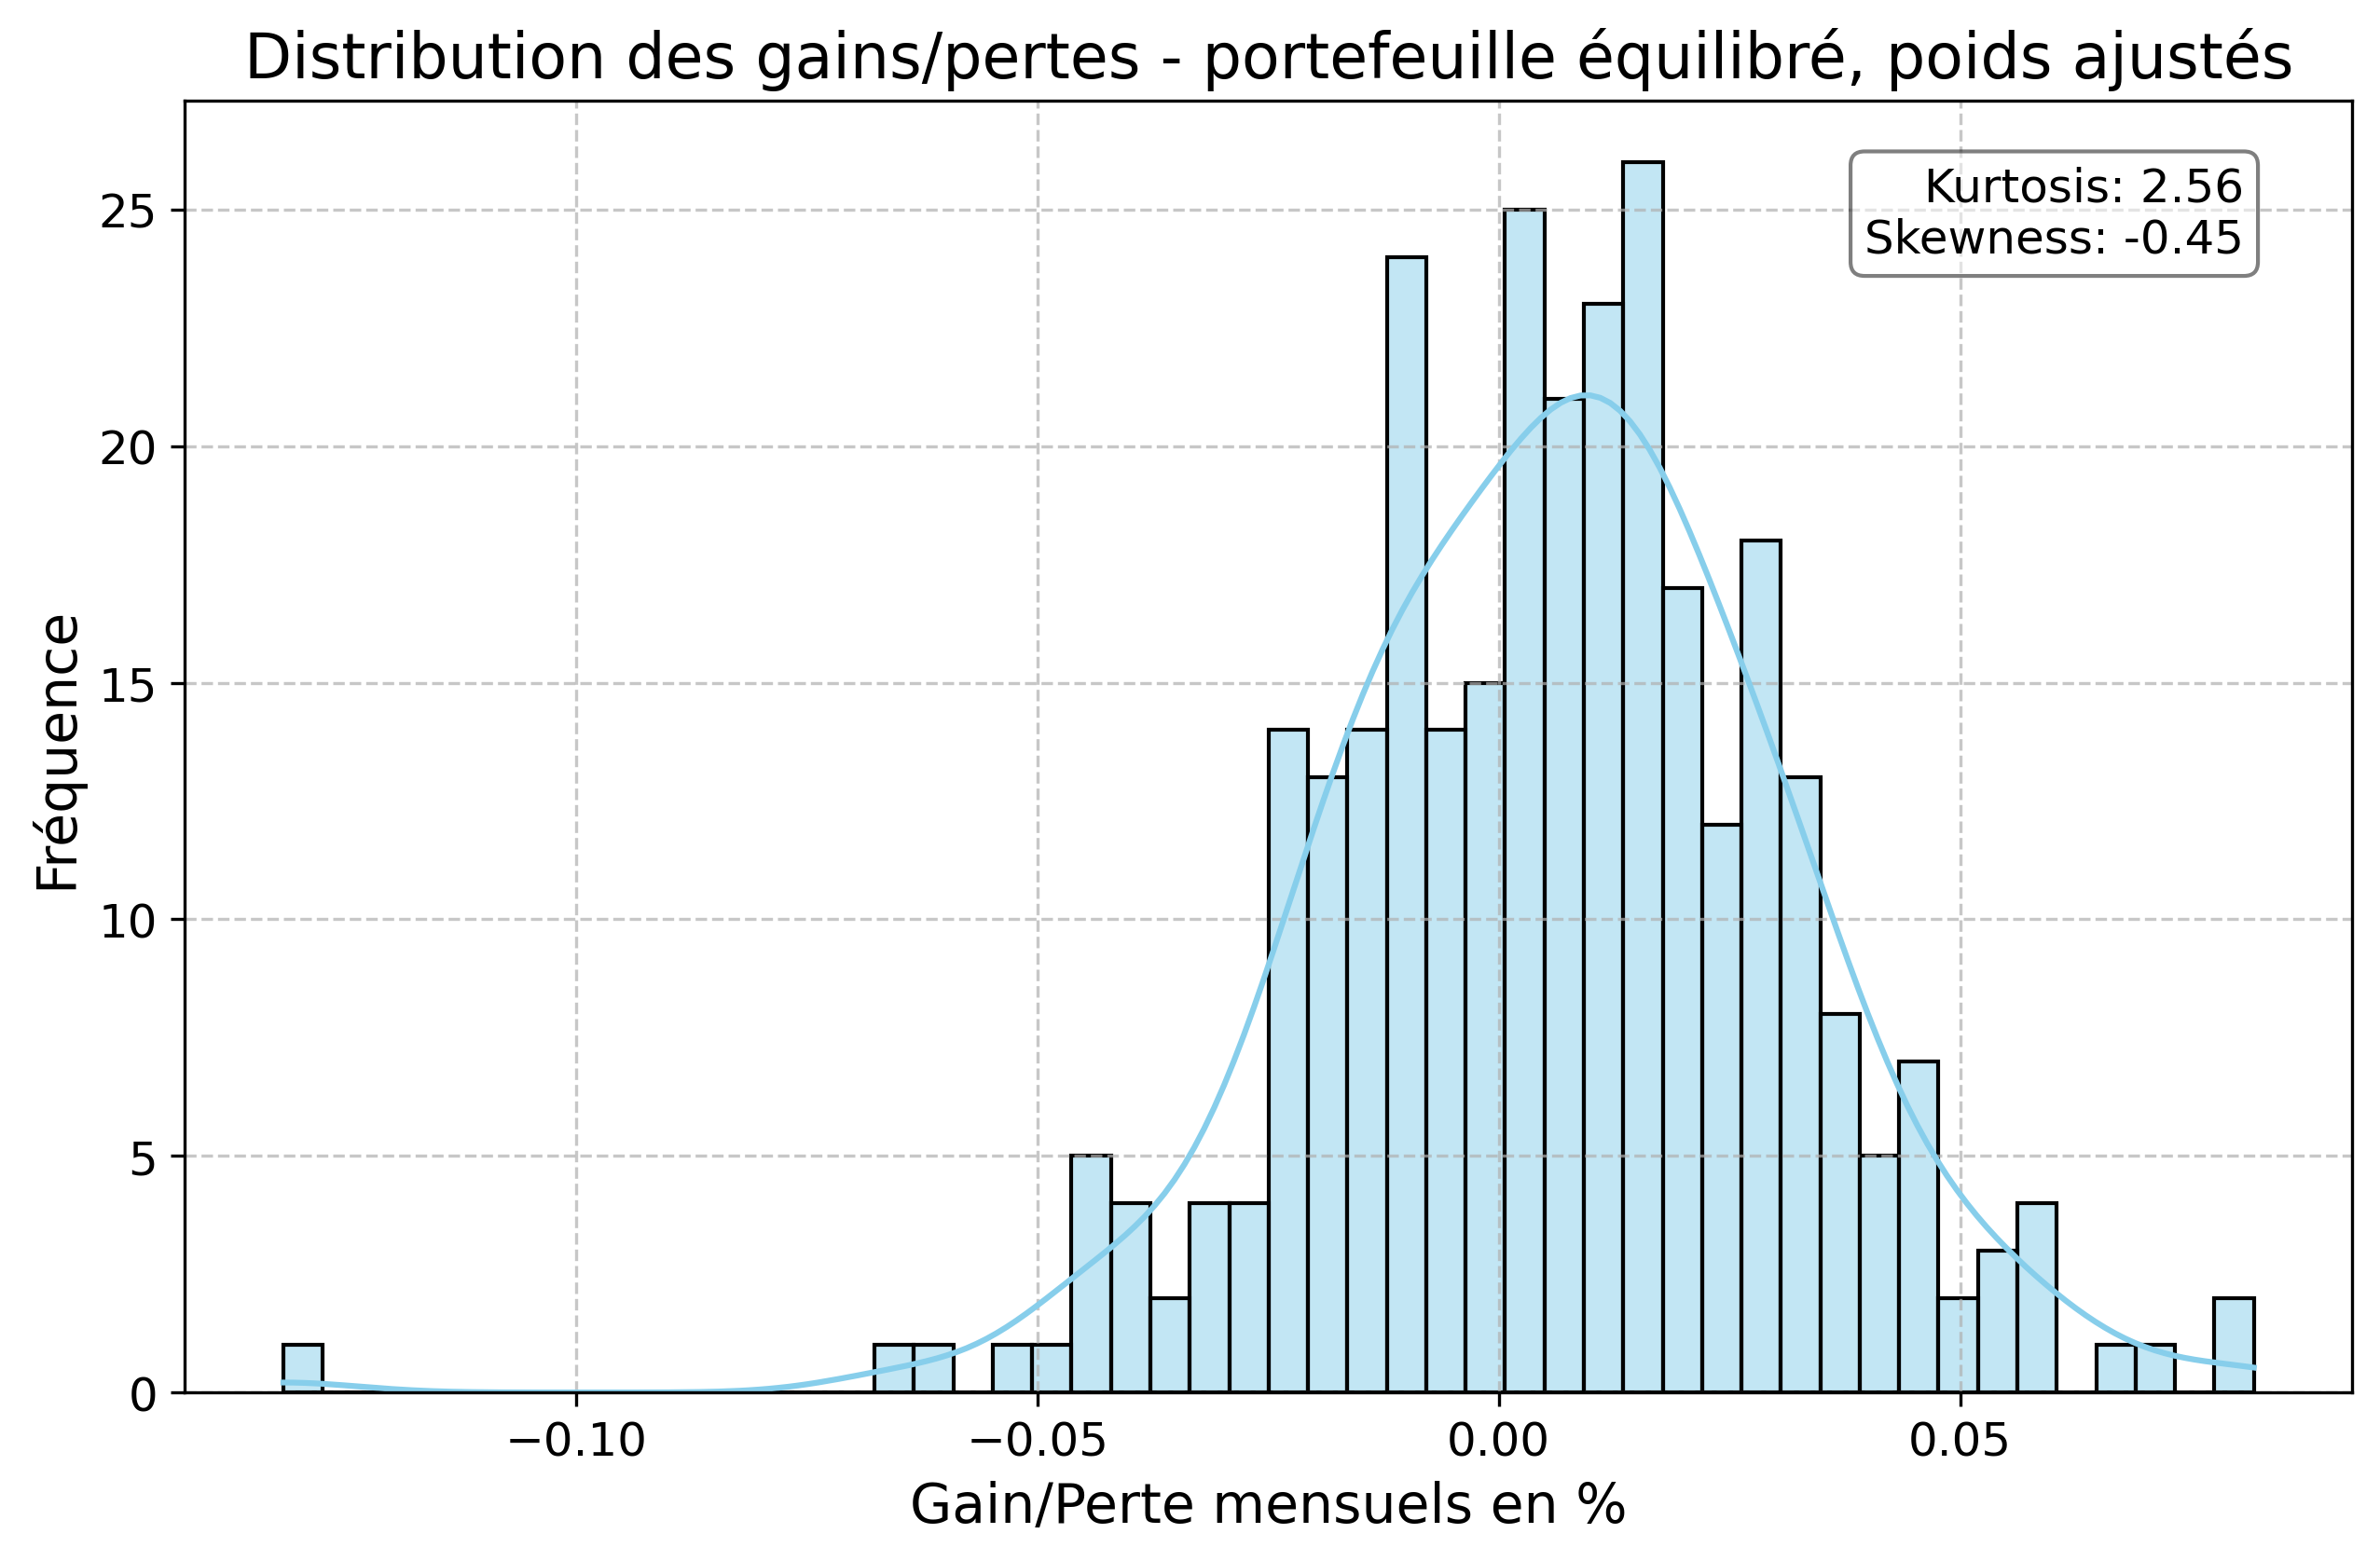

In [15]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns2, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns2)
skewness = skew(portfolio_returns2)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Distribution des gains/pertes - portefeuille équilibré, poids ajustés', fontsize=16)
plt.xlabel('Gain/Perte mensuels en %', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [16]:
# Parameters of the CORPORATE EU Bond ETF
yield_rate = 0.0334       # Current yield (3.33%)
duration = 4.43           # Duration in years
convexity = 22.71          # Convexity
maturity = 5.65       # Maturity in years

# Changes in yield (150 bps increase and decrease)
delta_yields = [0.015, -0.015]  # +1.5% and -1.5%

# Portfolio weights scenarios
weights = [0.10, 0.15]  # 10% and 15%

# Initialize a dictionary to store results
results = {}

for delta_y in delta_yields:
    # Calculate percentage price change using duration and convexity
    delta_p_over_p = (-duration * delta_y) + (0.5 * convexity * (delta_y ** 2))
    delta_p_over_p_percent = delta_p_over_p * 100  # Convert to percentage
    
    # Store results for each weight scenario
    for weight in weights:
        portfolio_impact = weight * delta_p_over_p_percent  # Portfolio impact in percentage
        scenario = f"Yield Change: {delta_y*100:+.1f}%, Weight: {weight*100:.0f}%"
        results[scenario] = portfolio_impact

# Display the results
print("EU Corporate Bonds Impact on Portfolio:")
for scenario, impact in results.items():
    print(f"{scenario}: {impact:.2f}%")

EU Corporate Bonds Impact on Portfolio:
Yield Change: +1.5%, Weight: 10%: -0.64%
Yield Change: +1.5%, Weight: 15%: -0.96%
Yield Change: -1.5%, Weight: 10%: 0.69%
Yield Change: -1.5%, Weight: 15%: 1.04%


In [17]:
# Parameters of the TREASURY Bills ETF
yield_rate = 0.0472       # Current yield (4.72%)
duration = 0.3          # Duration in years
convexity = 3.30          # Convexity
maturity = 0.31      # Maturity in years

# Changes in yield (150 bps increase and decrease)
delta_yields = [0.015, -0.015]  # +1.5% and -1.5%

# Portfolio weights scenarios
weights = [0.10, 0.15]  # 10% and 15%

# Initialize a dictionary to store results
results = {}

for delta_y in delta_yields:
    # Calculate percentage price change using duration and convexity
    delta_p_over_p = (-duration * delta_y) + (0.5 * convexity * (delta_y ** 2))
    delta_p_over_p_percent = delta_p_over_p * 100  # Convert to percentage
    
    # Store results for each weight scenario
    for weight in weights:
        portfolio_impact = weight * delta_p_over_p_percent  # Portfolio impact in percentage
        scenario = f"Yield Change: {delta_y*100:+.1f}%, Weight: {weight*100:.0f}%"
        results[scenario] = portfolio_impact

# Display the results
print("Treasury Bills Impact on Portfolio:")
for scenario, impact in results.items():
    print(f"{scenario}: {impact:.2f}%")

Treasury Bills Impact on Portfolio:
Yield Change: +1.5%, Weight: 10%: -0.04%
Yield Change: +1.5%, Weight: 15%: -0.06%
Yield Change: -1.5%, Weight: 10%: 0.05%
Yield Change: -1.5%, Weight: 15%: 0.07%


**END OF FILE**